# Supplementary Report: Clustering

This is a **supporting notebook** for the final project for the Summer 2024 session of Intro to Data-Centric Computing. This report is focused on clustering the data found in the main notebook, which can be found in the zipped submission folder.

## Cluster Analysis - Proposal

In this section, we will perform initial cluster analysis, using the skills discussed up to this point in the semester.

### Setup

Since the input for this problem was designed to be largely uncorrelated, it would be appropriate for us to use the transformed output for clustering, then apply those clusters to the input. This way, we can use those clusters to see if any meaningful divisions emerge within the input space.

The original output variables were both fairly skewed. Therefore, we will use the transformations of the two continuous output variables, `log_mass` and `log_pressure`, for clustering. (The transformations as well as the marginal histograms for both the original and transformed columns for these variables can be found earlier in this notebook.)

There is no missing data in this data set - all cases are complete. Therefore, we don't need to drop any rows or otherwise handle missings in the data.

### Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

### Read data

In [2]:
df = pd.read_csv('cyclone_model_runs.csv')

### Transform outputs

In [3]:
df_copy = df.copy()
df_copy['log_mass'] = np.log(df_copy.mass)

In [4]:
df_copy['pressure_shift'] = df_copy.pressure + 150
df_copy['log_pressure'] = np.log(df_copy.pressure_shift)

In [5]:
df_copy['bin_mass'] = np.where(df_copy.mass > df_copy.mass.median(), 1, 0)

### KMeans: Initial Clusters

First, we'll work with KMeans using two clusters.

We'll begin by importing additional modules for preprocessing, decomposition, and clustering from scikit-learn.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Since we're interested in clustering on `log_mass` and `log_pressure`, let's copy those columns into a new dataframe.

In [7]:
df_output_features = df_copy.loc[:,['log_pressure', 'log_mass']].copy()

`log_pressure` and `log_mass` aren't on wildly different orders of magnitude, but they *are* different. We can scale the data accordingly using `StandardScaler`. 

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


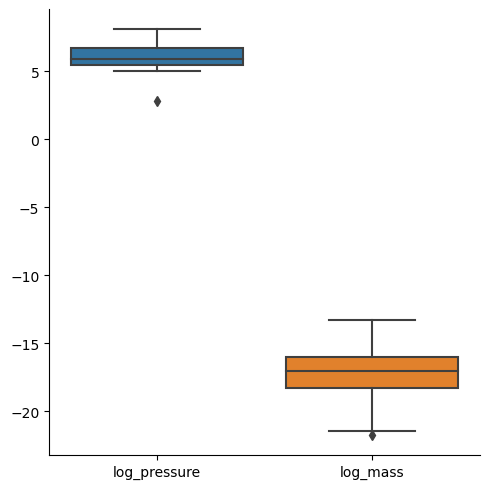

In [8]:
sns.catplot(data = df_output_features, kind='box')
plt.show()

In [9]:
Xdf_output_features = StandardScaler().fit_transform(df_output_features)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


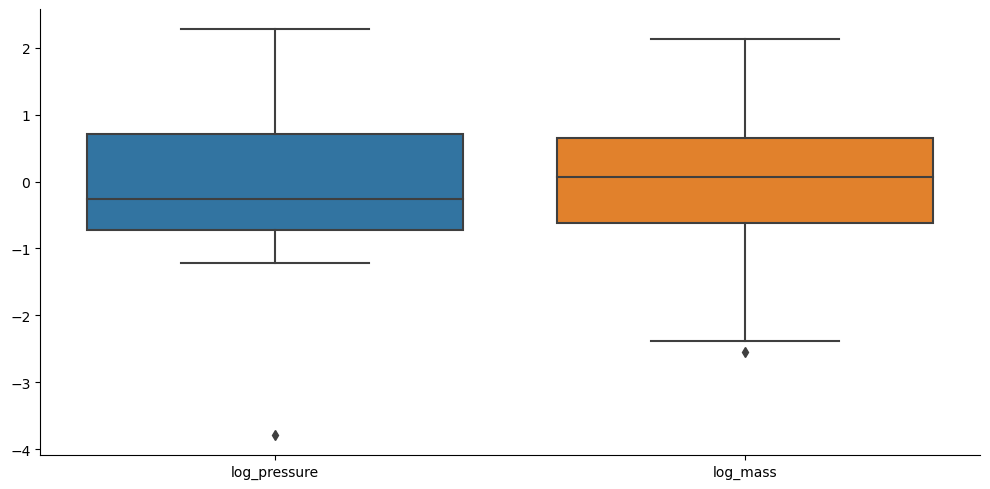

In [10]:
sns.catplot(data = pd.DataFrame(Xdf_output_features, columns=df_output_features.columns), kind='box', aspect=2)
plt.show()

Now, the variables are scaled similarly. Since we had no missing values to handle, this data is ready for KMeans.

We can initialize, fit, and predict in one line, similar to what we did for `StandardScaler`.

In [11]:
clusters_2 = KMeans(n_clusters=2, random_state=0, n_init=25, max_iter=500).fit_predict(Xdf_output_features)

After applying KMeans, write the cluster assignments into a fresh copy of the dataframe for visualization.

In [12]:
df_cluster_copy = df_copy.copy()
df_cluster_copy['k2'] = pd.Series(clusters_2, index=df_cluster_copy.index ).astype('category')

In [13]:
df_cluster_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   model           96 non-null     int64   
 1   r_barrel        96 non-null     float64 
 2   r_vortex        96 non-null     float64 
 3   h_vortex        96 non-null     float64 
 4   w_inlet         96 non-null     float64 
 5   h_inlet         96 non-null     float64 
 6   mass            96 non-null     float64 
 7   pressure        96 non-null     float64 
 8   log_mass        96 non-null     float64 
 9   pressure_shift  96 non-null     float64 
 10  log_pressure    96 non-null     float64 
 11  bin_mass        96 non-null     int64   
 12  k2              96 non-null     category
dtypes: category(1), float64(10), int64(2)
memory usage: 9.3 KB


In [14]:
df_cluster_copy.k2.value_counts()

k2
0    51
1    45
Name: count, dtype: int64

Note that the clusters are relatively balanced, though not exactly equal.

Let's visualize `log_pressure` and `log_mass` grouped by `k2`:

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


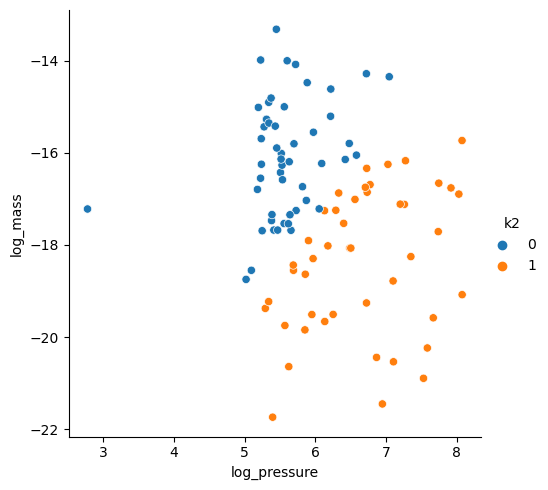

In [15]:
sns.relplot(data = df_cluster_copy, x='log_pressure', y='log_mass', hue='k2')
plt.show()

### PCA: Initial Clusters

Next, we'll use PCA to support the cluster analysis visualization.

Since we've already preprocessed our data for KMeans, we only need to initialize, fit, and transform in order to obtain our principal components.

In [16]:
pca_outputs = PCA(n_components=2).fit_transform(Xdf_output_features)

Convert results to dataframe and visualize:

In [17]:
pca_outputs_df = pd.DataFrame(pca_outputs, columns=['pc01', 'pc02'])

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


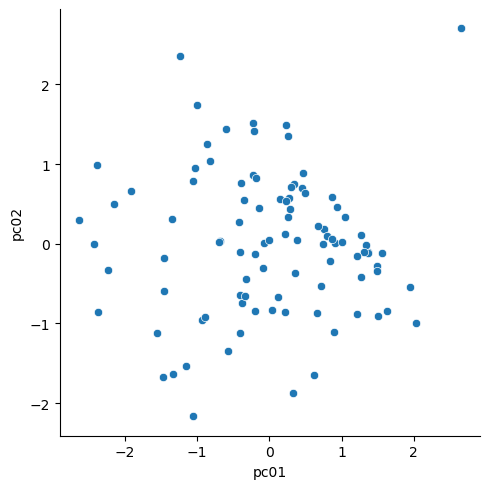

In [18]:
sns.relplot(data = pca_outputs_df, x='pc01', y='pc02')
plt.show()

Now we can add the cluster assignments from KMeans clustering and visualize again using the results from PCA.

In [19]:
pca_outputs_df['k2'] = pd.Series(clusters_2, index=pca_outputs_df.index ).astype('category')

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


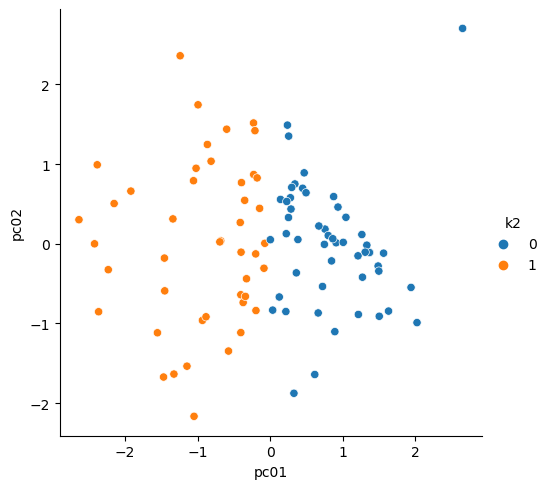

In [20]:
sns.relplot(data = pca_outputs_df, x='pc01', y='pc02', hue='k2')
plt.show()

This visualization does not seem significantly easier to interpret than the initial clustering. Since we're only working with two variables and those variables aren't very strongly correlated, I wonder if dimensionality reduction with PCA is not as useful here?

### KMeans: Optimal Clustering

Next, let's generate a knee-bend plot to identify the optimal number of clusters for KMeans.

In [21]:
tots_within = []

K = range(1, 46)

for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    km = km.fit(Xdf_output_features)
    
    tots_within.append(km.inertia_)

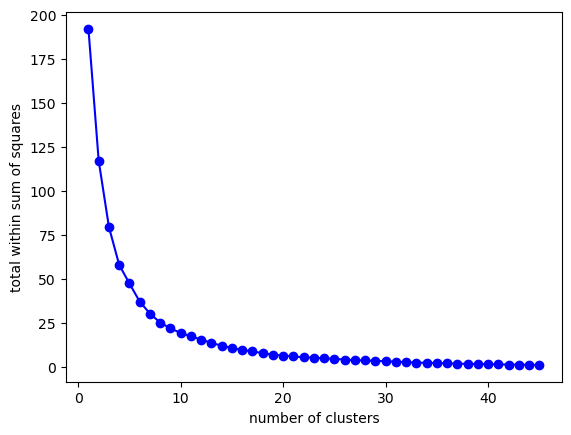

In [22]:
fig, ax = plt.subplots()

ax.plot(K, tots_within, 'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

The knee-bend appears to straighten after 6, so we'll try KMeans again with 6 clusters.

In [23]:
clusters_6 = KMeans(n_clusters=6, random_state=0, n_init=25, max_iter=500).fit_predict(Xdf_output_features)

In [24]:
df_cluster_copy['k6'] = pd.Series(clusters_6, index=df_cluster_copy.index ).astype('category')

In [25]:
df_cluster_copy.k6.value_counts()

k6
0    27
4    25
1    19
3    14
2    10
5     1
Name: count, dtype: int64

The counts for each cluster are less equal for this clustering attempt.

If we visualize this on a scatter plot using `log_pressure` and `log_mass`, we can see that the 'dense' section that we noticed earlier is categorized into two clusters, while the remaining bulk of the data accounts for three more clusters.

The single originally-negative observation of `pressure` is considered to be its own cluster.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


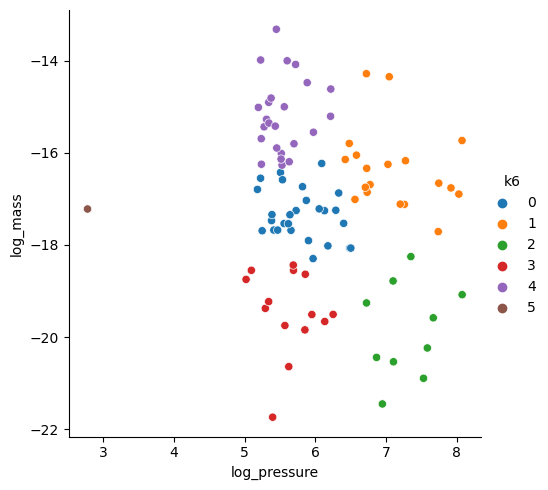

In [26]:
sns.relplot(data = df_cluster_copy, x='log_pressure', y='log_mass', hue='k6')
plt.show()

### PCA: Optimal Clustering

Now, let's visualize the cluster results using our components from PCA.

In [27]:
pca_outputs_df['k6'] = pd.Series(clusters_6, index=pca_outputs_df.index ).astype('category')

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


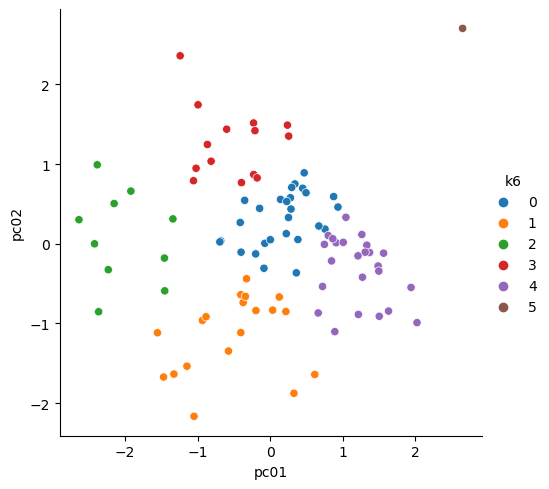

In [28]:
sns.relplot(data = pca_outputs_df, x='pc01', y='pc02', hue='k6')
plt.show()

Again, this visualization doesn't seem to be much easier to interpret than the original. A lot of the same observations can be made - they simply appear to be flipped onto different axes.

### Discussion

There don't seem to be any obvious known grouping variables in this data set, since all of the inputs and outputs are continuous, so it's difficult to say whether the optimal number of clusters aligns with any known groups.

However, the clusters do seem to make sense - the very far data point is its own cluster, while the bulk of the data is split into five additional clusters, two of which are slightly more dense than the rest.

If we were to explore clustering further, I'd like to check the clusters for `k` = 4 as well.

Let's take a closer look at the conditional distributions of the clustering variables given the clusters we've identified. First, we'll examine the results from KMeans with 2 clusters.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


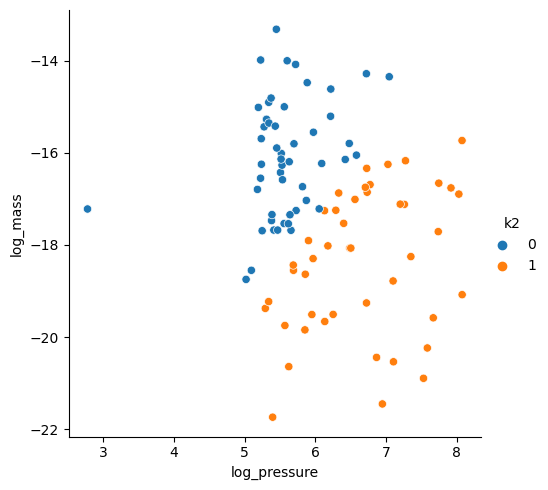

In [29]:
sns.relplot(data = df_cluster_copy, x='log_pressure', y='log_mass', hue='k2')
plt.show()

The first cluster, cluster 0, includes the lone point on the left-hand side of the plot as well as a group containing 'lower' values of `log_pressure` with 'higher' values of `log_mass`. The second cluster, cluster 1, contains the remaining observations, 'lower' values of `log_mass` with 'higher' values of `log_pressure`. Aside from the single faraway observation, cluster 0 appears to be more densely populated than cluster 1.

I'd also like to take a moment to look at the plot of `log_pressure` and `log_mass` grouped by 2 clusters with shape markers determined by `bin_mass`. Note that many of the points for `bin_mass` = 1 appear to have been associated with cluster 0, while many of the points for `bin_mass` = 0 appear to have been associated with cluster 1.

However, there are still multiple points for both values of `bin_mass` that were not clustered accurately in this way.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


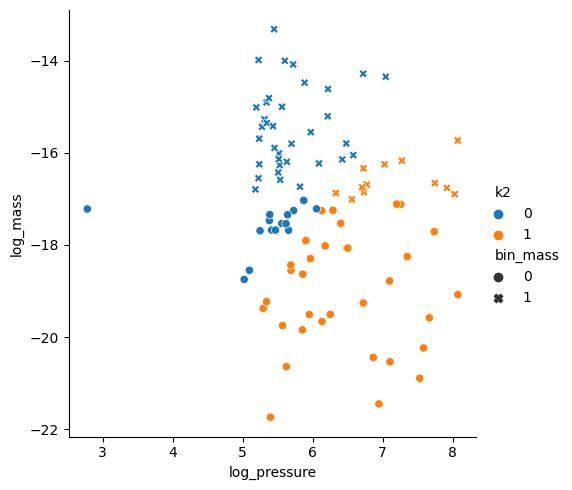

In [30]:
sns.relplot(data = df_cluster_copy, x='log_pressure', y='log_mass', hue='k2', style='bin_mass')
plt.show()

Now, let's look at the conditional distributions of the clustering variables given the results of applying KMeans with 6 clusters.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


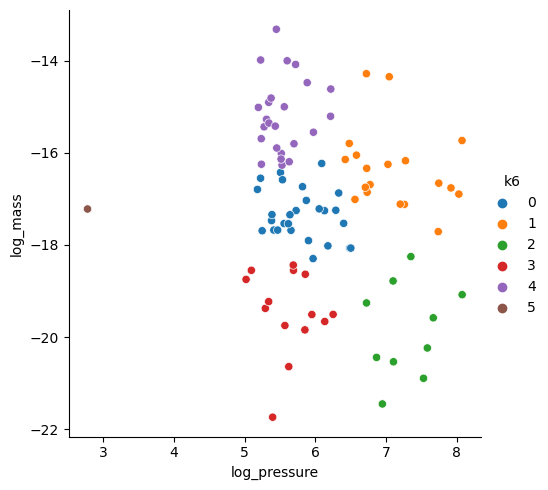

In [31]:
sns.relplot(data = df_cluster_copy, x='log_pressure', y='log_mass', hue='k6')
plt.show()

As mentioned in the earlier KMeans section of this notebook, the 'dense' section that we noticed previously is now described by clusters 0 and 4, while the rest of the data is categorized into clusters 1, 2, and 3. Cluster 5 is only a single point, and it is very distant from the rest of the observations in the data set.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


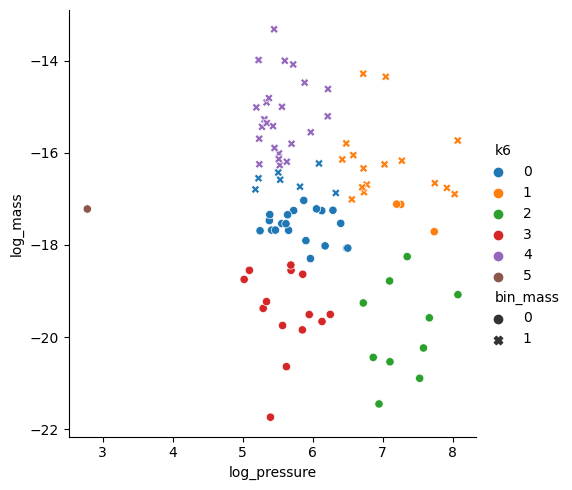

In [32]:
sns.relplot(data = df_cluster_copy, x='log_pressure', y='log_mass', hue='k6', style='bin_mass')
plt.show()

When we add `bin_mass` into the picture as a shape marker, we discover that 6 clusters provides a more 'accurate' (though still imperfect) clustering for the two values of `bin_mass` - all values for cluster 4 are associated with `bin_mass` = 1, as well as most of the values for cluster 1 and some of the values for cluster 0. All of the values for clusters 2, 3, and 5 are associated with `bin_mass` = 0, as well as most of the values for cluster 0 and some of the values for cluster 1.

Cluster 0 appears to have the greatest degree of 'uncertainty' with respect to `bin_mass`, followed by cluster 1.

Finally, I'd also like to take a moment to look at the plots for `log_mass` and `log_pressure` for each input variable, to see if any meaningful patterns emerge from applying the results of clustering the output to the input space.

In [33]:
df_copy['k2'] = df_cluster_copy['k2']
df_copy['k6'] = df_cluster_copy['k6']

lf_copy = df_copy.drop(columns=['mass', 'pressure', 'pressure_shift']).copy().\
reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'model', 'log_mass', 'log_pressure', 'bin_mass', 'k2', 'k6'], 
     value_vars=['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet'], 
     value_name='input_value',
     var_name='input_name',
     ignore_index=True)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


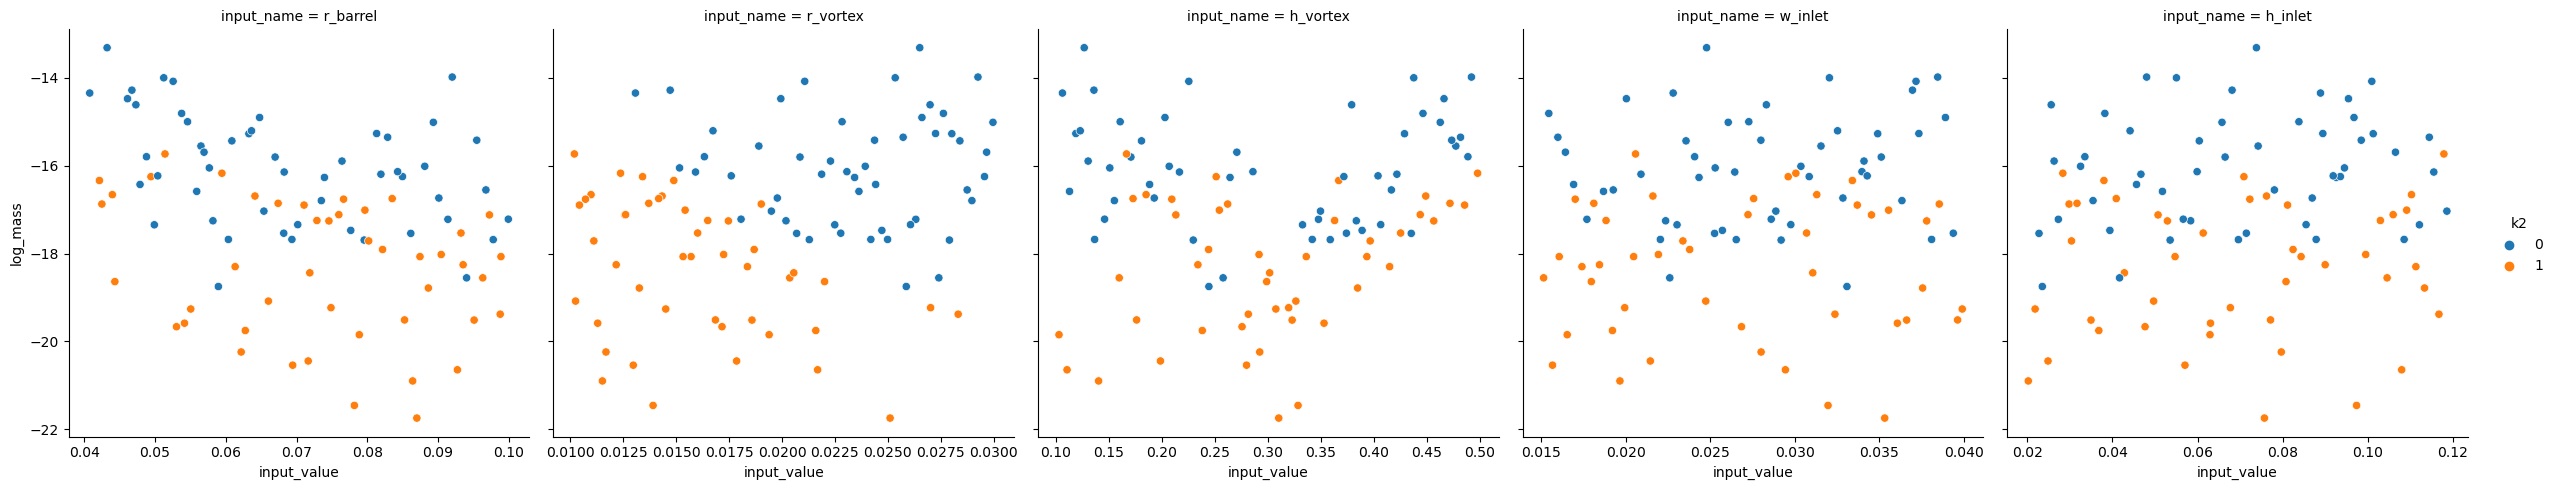

In [34]:
sns.relplot(data = lf_copy, x='input_value', y='log_mass', hue='k2', col='input_name',
            facet_kws={'sharex': False, 'sharey': True})

plt.show()

Generally speaking, with 2 clusters, higher values of `log_mass` are associated with cluster 0, while lower values are associated with cluster 1. This applies across the entire range of input values for every input variable.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


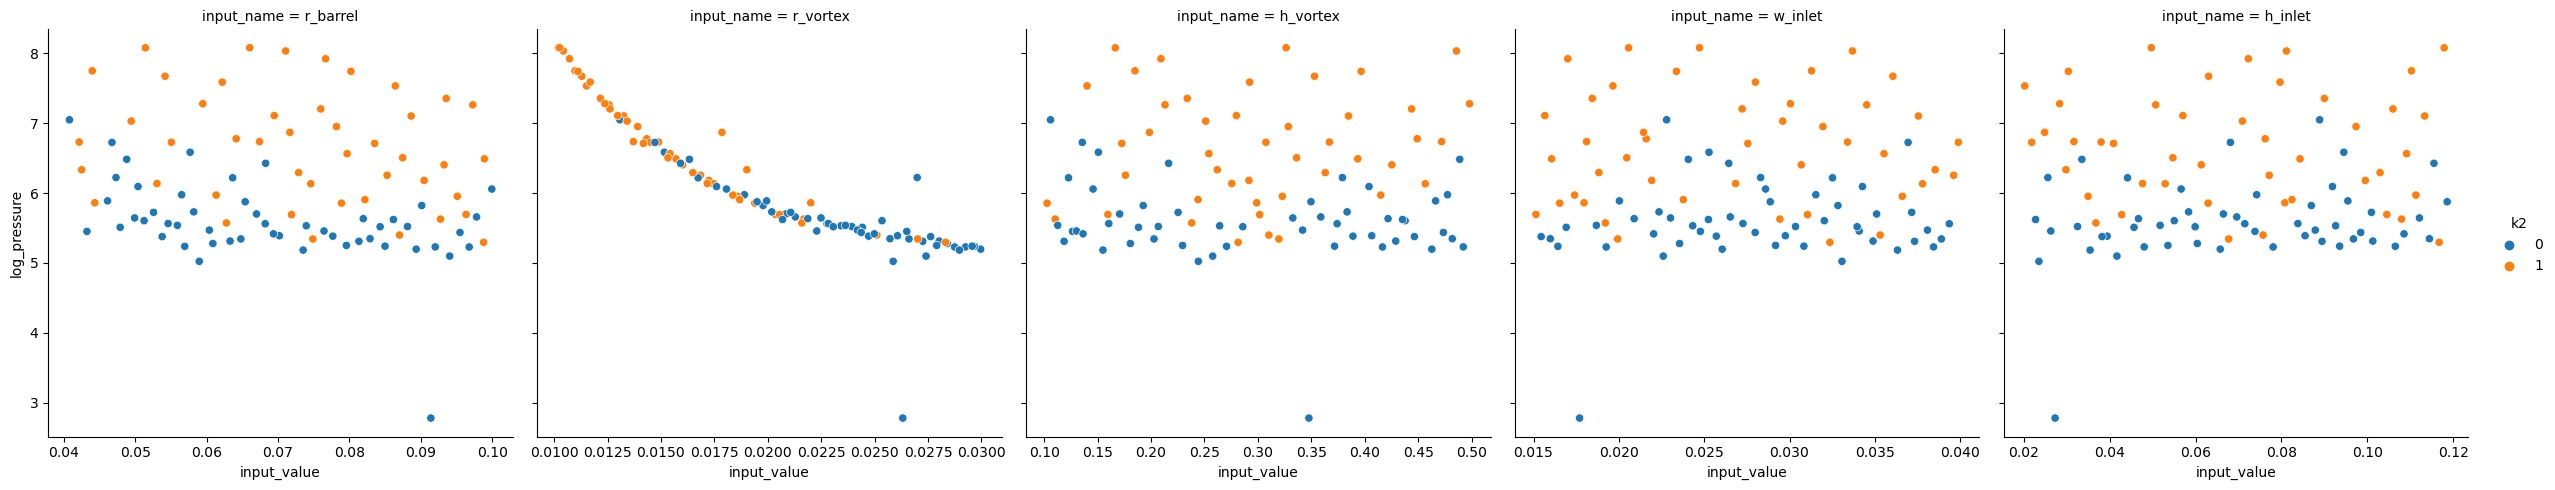

In [35]:
sns.relplot(data = lf_copy, x='input_value', y='log_pressure', hue='k2', col='input_name',
            facet_kws={'sharex': False, 'sharey': True})

plt.show()

The opposite behavior can be observed for `log_pressure`, where higher values are typically associated with cluster 1 while lower values are typically associated with cluster 0.

When we include the clusters from our `k` = 6 clustering, the resulting plots look like this:

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


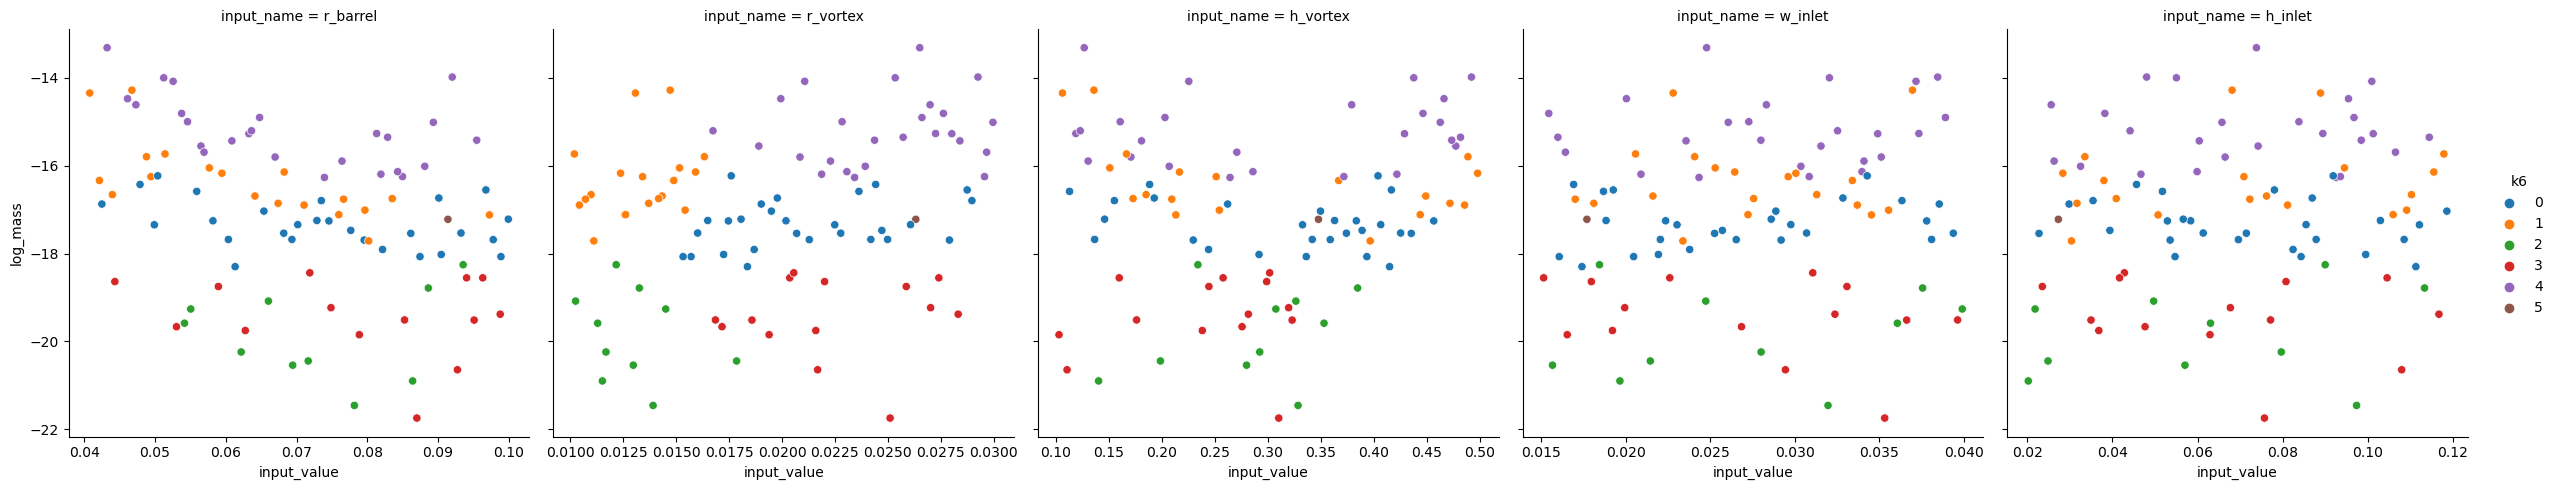

In [36]:
sns.relplot(data = lf_copy, x='input_value', y='log_mass', hue='k6', col='input_name',
            facet_kws={'sharex': False, 'sharey': True})

plt.show()

For all inputs, we see that clusters 2 and 3 are associated with 'lower' values of `log_mass`, while clusters 0 and 5 are associated with 'mid' values and clusters 1 and 4 are associated with 'high' values.

For most inputs, this holds true across the entire range of the input variable; however, for `r_vortex`, we can additionally observe that clusters 1 and 2 are associated with lower values of the input variable, while the remaining clusters are associated with mid and high values.

We also notice that, for `h_vortex`, clusters 1 and 4 only appear at low and high values of the input variable, not in the middle.

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


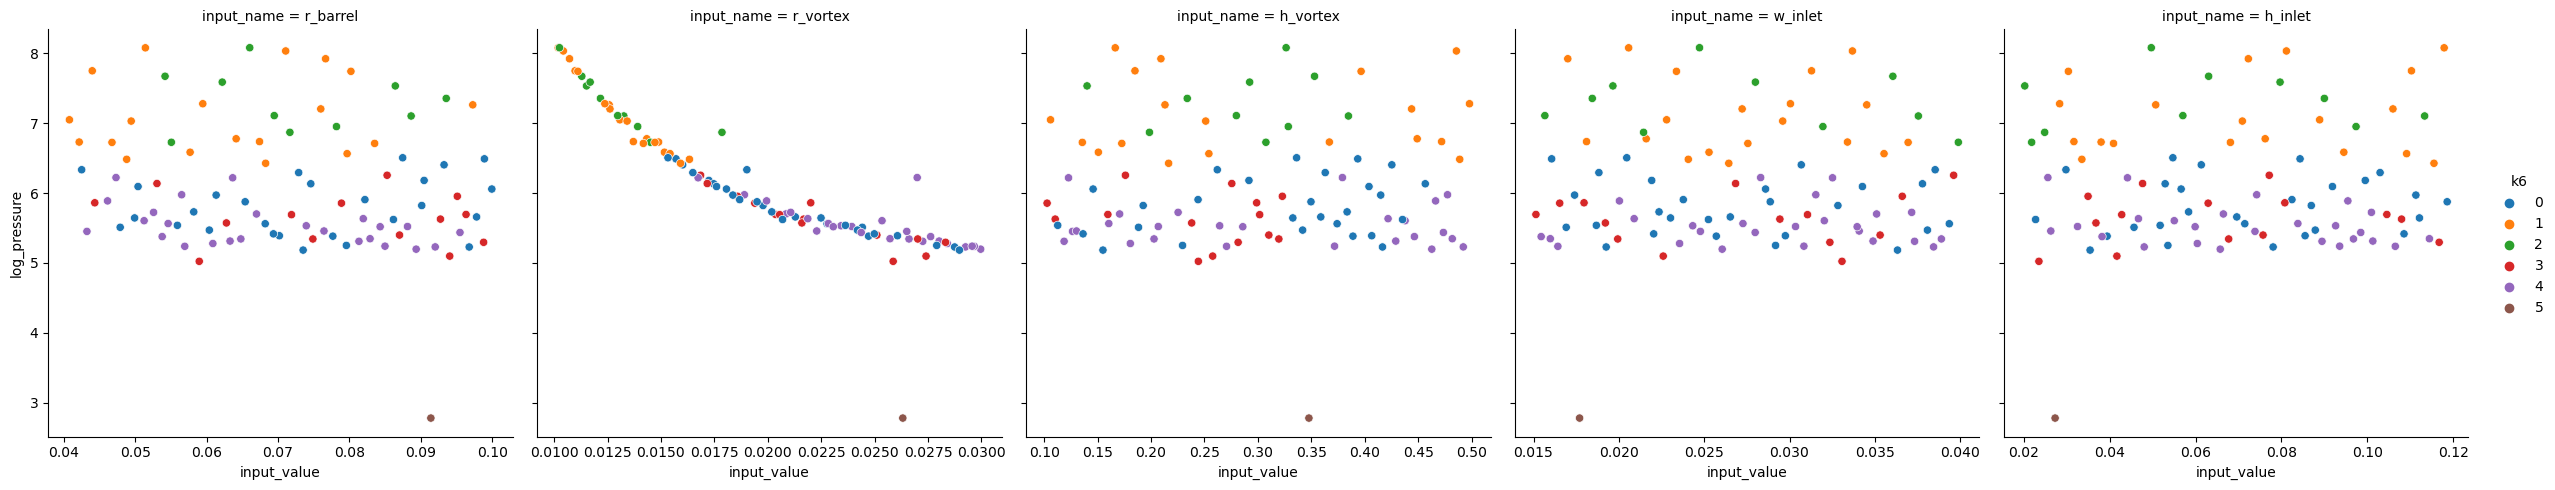

In [37]:
sns.relplot(data = lf_copy, x='input_value', y='log_pressure', hue='k6', col='input_name',
            facet_kws={'sharex': False, 'sharey': True})

plt.show()

For all inputs, we see that cluster 5 is located far away from the rest of the observations, while clusters 0, 3, and 4 are associated with relatively lower values of `log_pressure` and clusters 1 and 2 are associated with higher values. This holds across the entire range of input variables.

Note: this is the end of the material from the project proposal. The remaining material in this notebook is largely unstructured and unaccompanied by discussion text.

### Hierarchical Clustering

In [38]:
from scipy.cluster import hierarchy

In [39]:
hclust_complete = hierarchy.complete(Xdf_output_features)

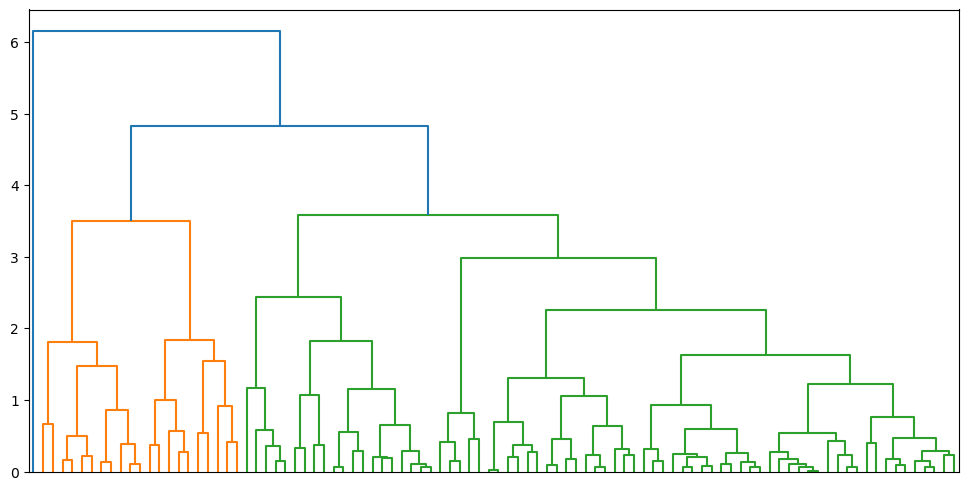

In [41]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram(hclust_complete, no_labels=True )

plt.show()

In [42]:
hclust_single = hierarchy.single(Xdf_output_features)

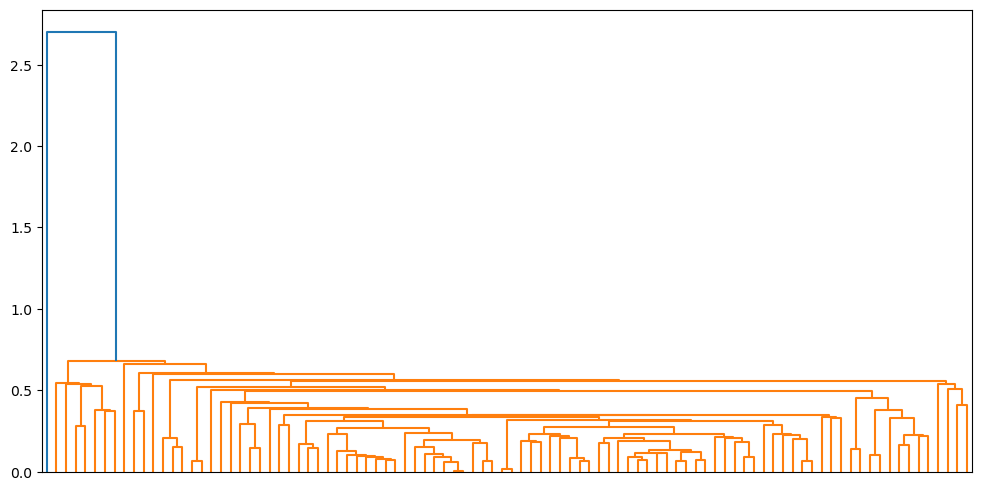

In [43]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram(hclust_single, no_labels=True )

plt.show()

In [44]:
hclust_average = hierarchy.average(Xdf_output_features)

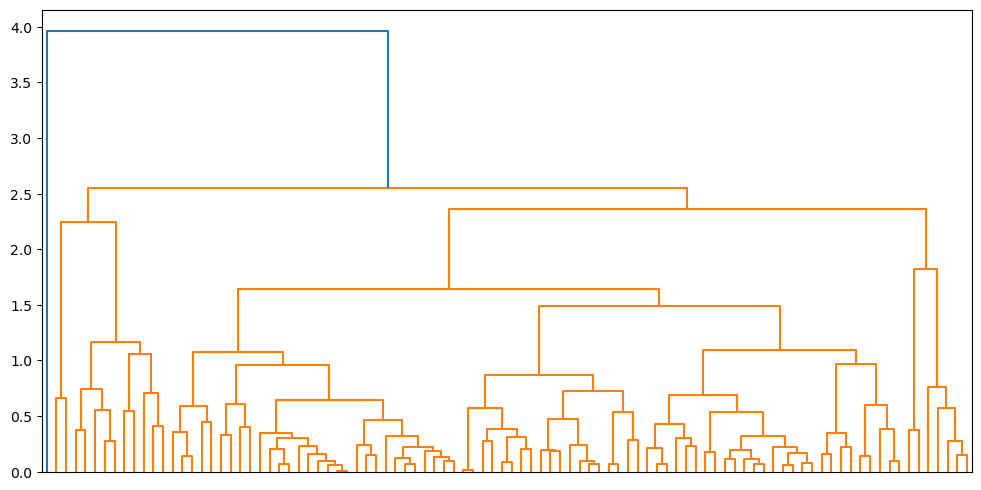

In [45]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram(hclust_average, no_labels=True )

plt.show()

In [46]:
hclust_centroid = hierarchy.centroid(Xdf_output_features)

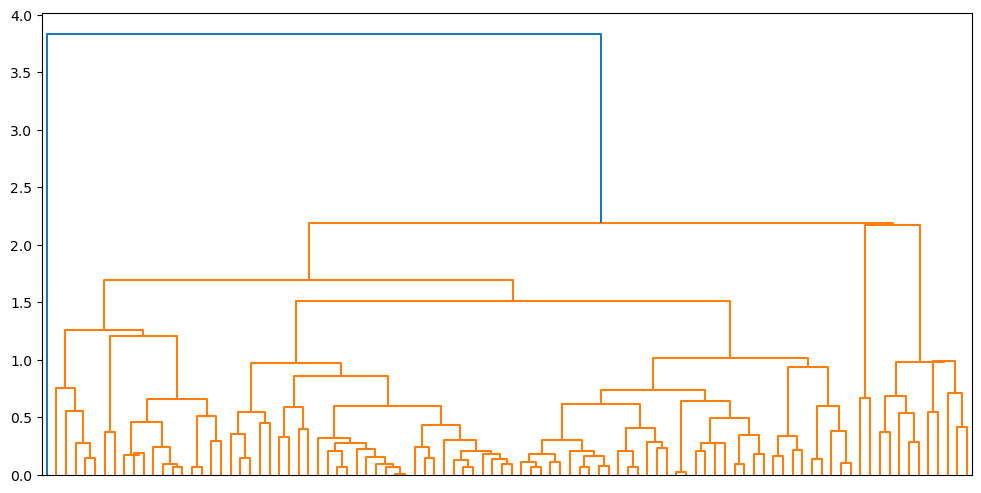

In [47]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram(hclust_centroid, no_labels=True )

plt.show()

In [48]:
hclust_ward = hierarchy.ward(Xdf_output_features)

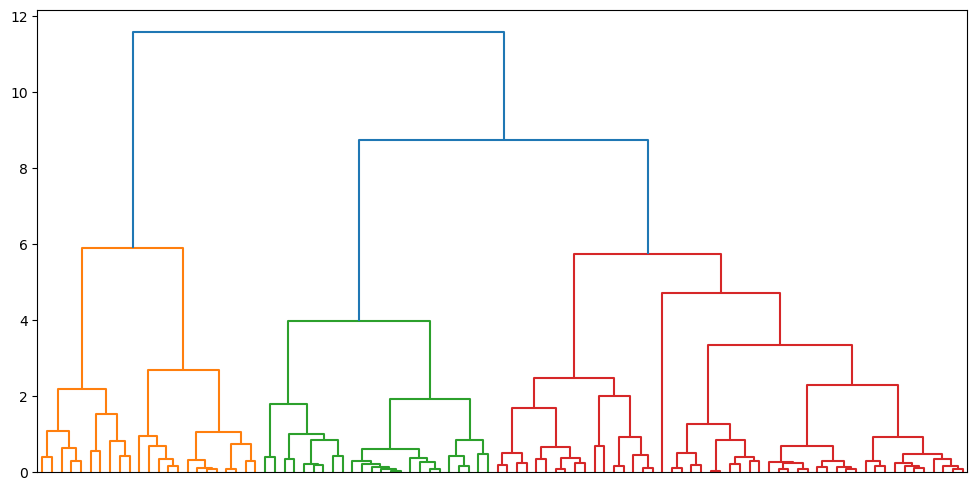

In [49]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram(hclust_ward, no_labels=True )

plt.show()

In [50]:
df_copy['hclust_3'] = pd.Series(hierarchy.cut_tree(hclust_ward, n_clusters=3).ravel(),
                                     index=df_copy.index ).astype('category')

In [51]:
df_copy.hclust_3.value_counts()

hclust_3
1    49
0    24
2    23
Name: count, dtype: int64

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


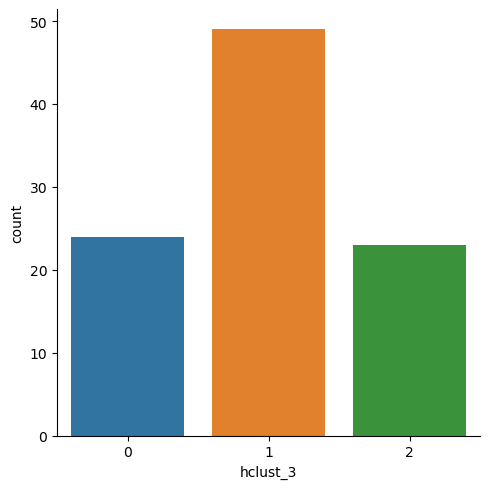

In [52]:
sns.catplot(data=df_copy, x='hclust_3', kind='count')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


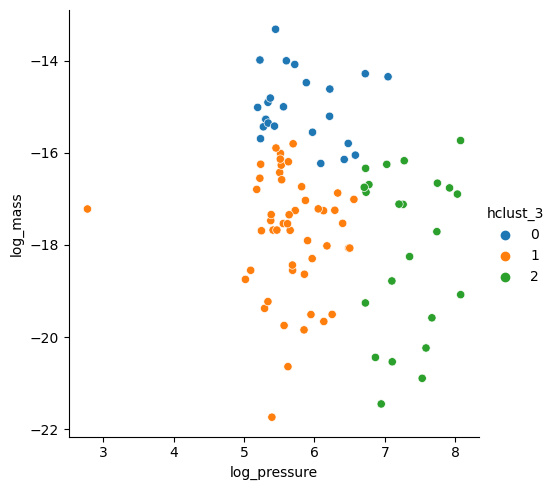

In [53]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_3')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


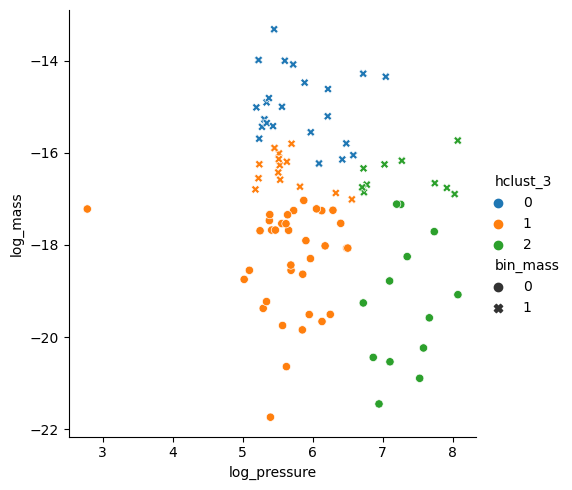

In [54]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_3', style='bin_mass')
plt.show()

In [55]:
lf_copy_h = df_copy.drop(columns=['mass', 'pressure', 'pressure_shift']).copy().\
reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'model', 'log_mass', 'log_pressure', 'bin_mass', 'hclust_3'], 
     value_vars=['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet'], 
     value_name='input_value',
     var_name='input_name',
     ignore_index=True)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


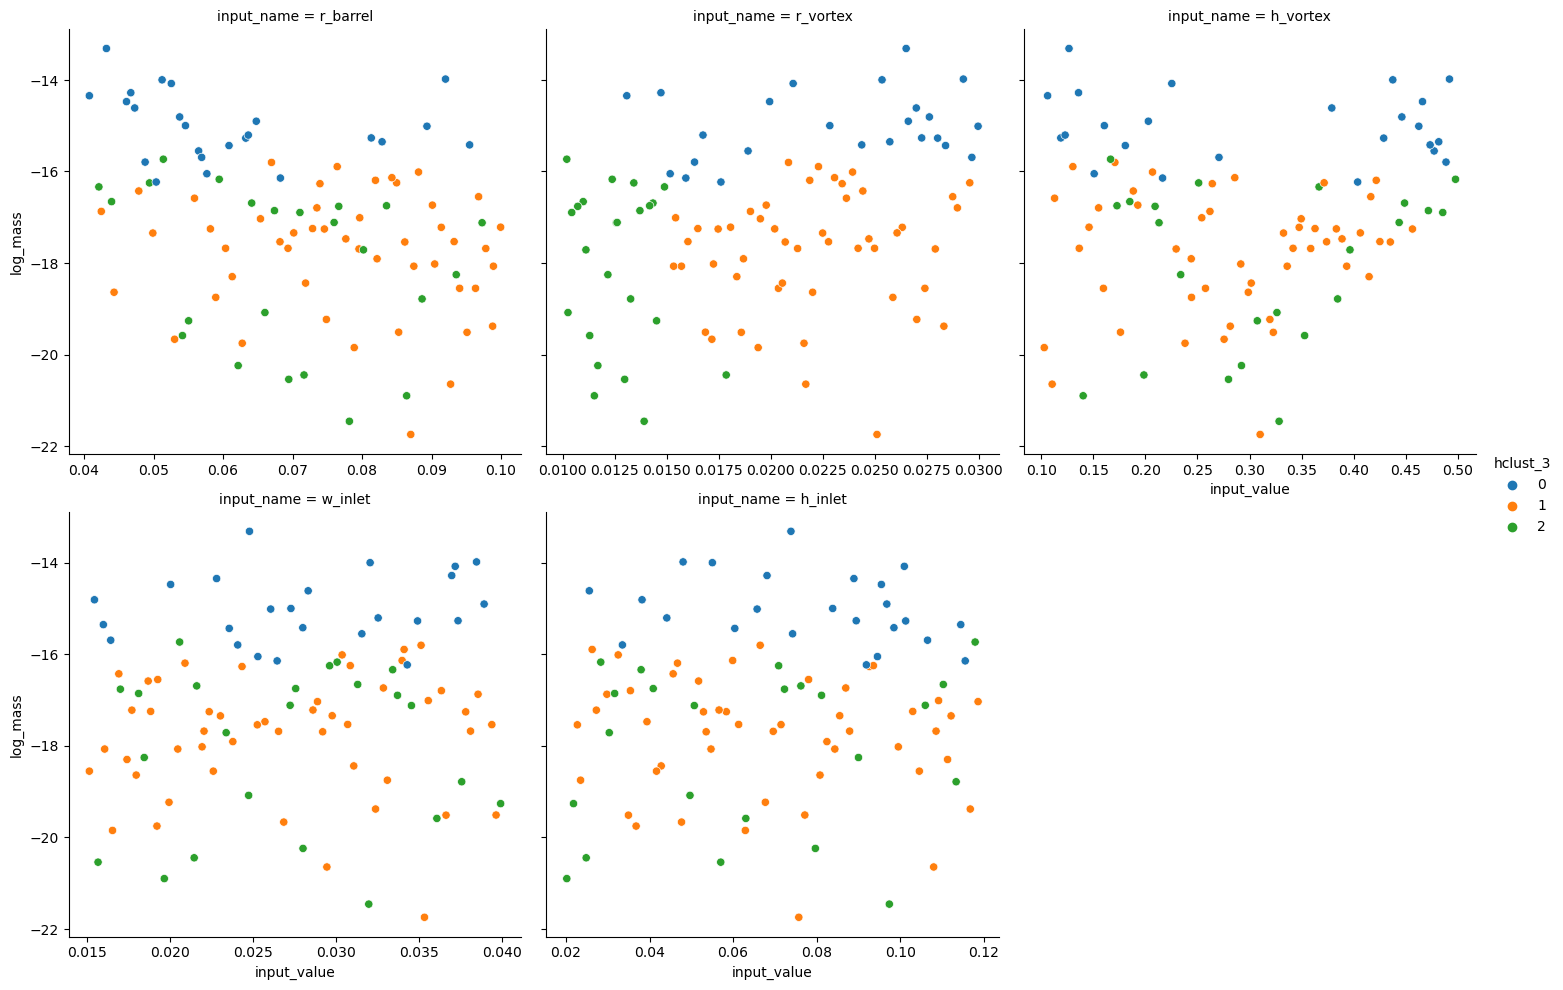

In [57]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_mass', hue='hclust_3', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


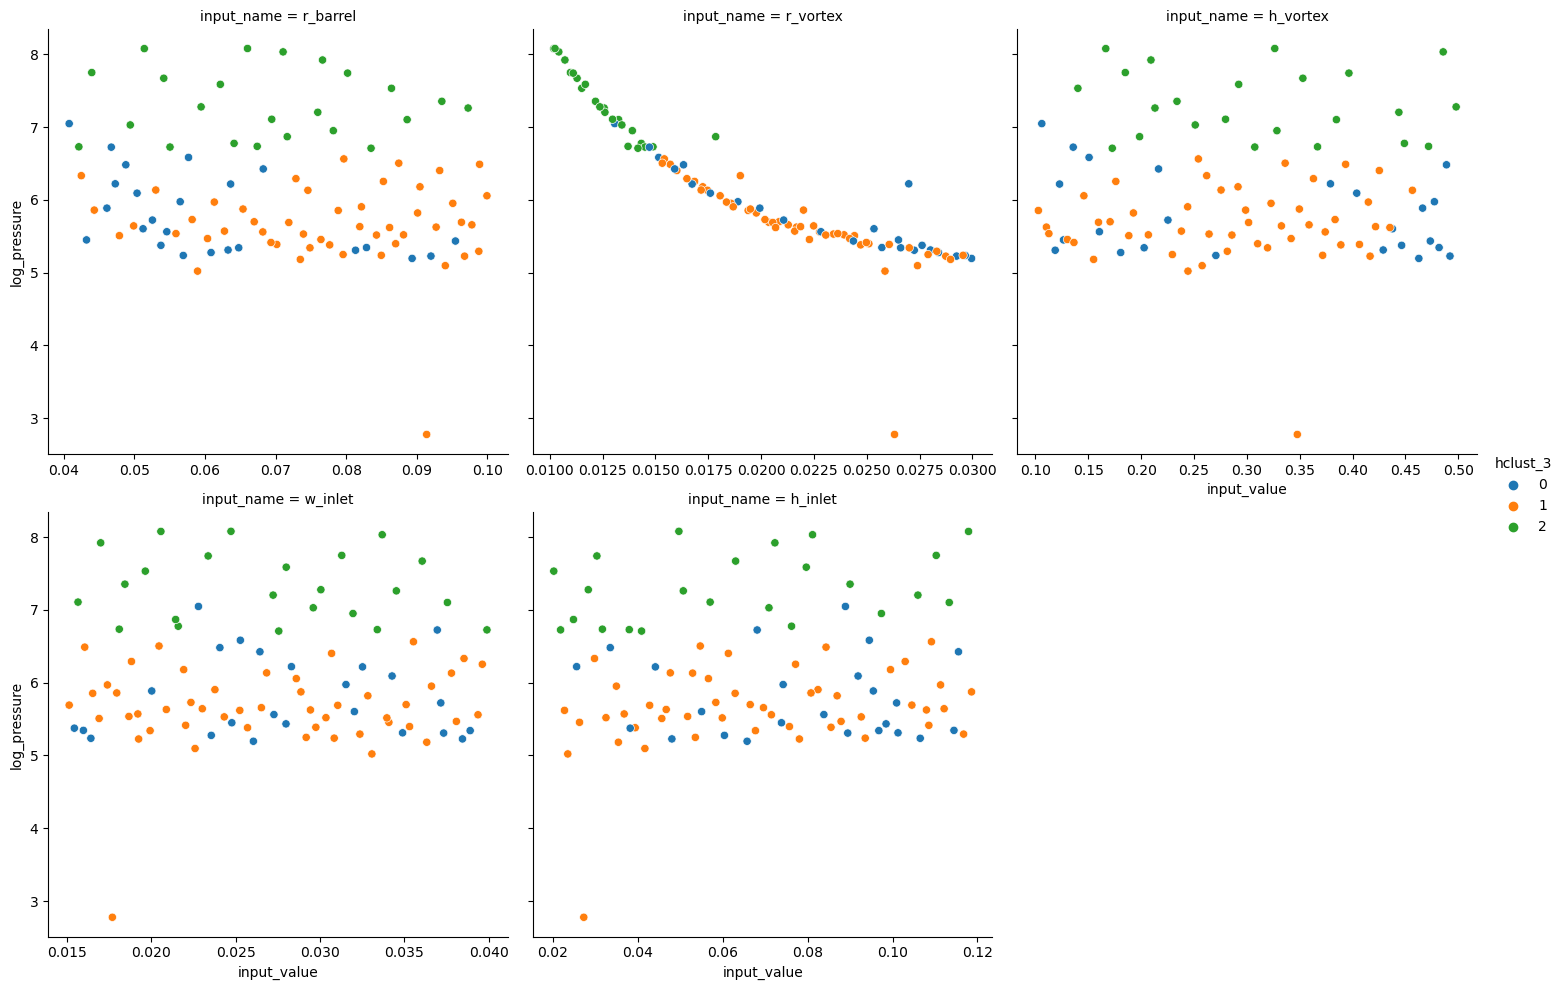

In [58]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_pressure', hue='hclust_3', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

In [66]:
df_copy['hclust_4'] = pd.Series(hierarchy.cut_tree(hclust_ward, n_clusters=4).ravel(),
                                     index=df_copy.index ).astype('category')

df_copy['hclust_5'] = pd.Series(hierarchy.cut_tree(hclust_ward, n_clusters=5).ravel(),
                                     index=df_copy.index ).astype('category')

df_copy['hclust_6'] = pd.Series(hierarchy.cut_tree(hclust_ward, n_clusters=6).ravel(),
                                     index=df_copy.index ).astype('category')

In [62]:
df_copy.hclust_4.value_counts()

hclust_4
1    49
0    24
3    13
2    10
Name: count, dtype: int64

In [67]:
df_copy.hclust_5.value_counts()

hclust_5
2    32
0    24
1    17
4    13
3    10
Name: count, dtype: int64

In [63]:
df_copy.hclust_6.value_counts()

hclust_6
3    31
0    24
1    17
5    13
4    10
2     1
Name: count, dtype: int64

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


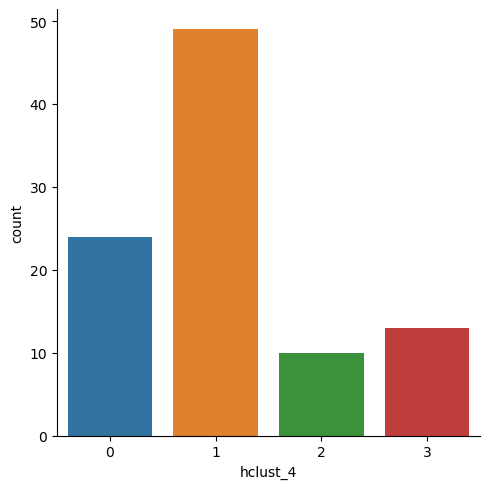

In [64]:
sns.catplot(data=df_copy, x='hclust_4', kind='count')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


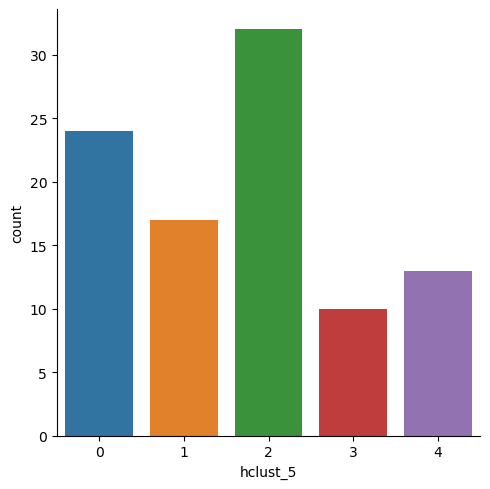

In [68]:
sns.catplot(data=df_copy, x='hclust_5', kind='count')
plt.show()

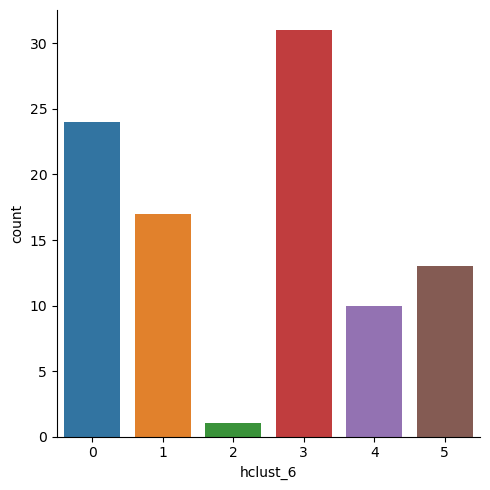

In [65]:
sns.catplot(data=df_copy, x='hclust_6', kind='count')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


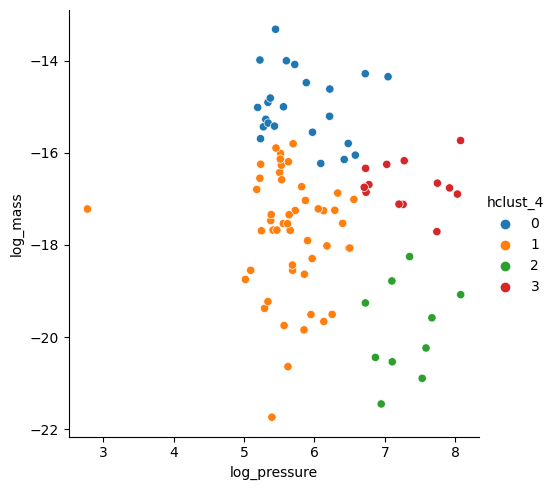

In [69]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_4')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


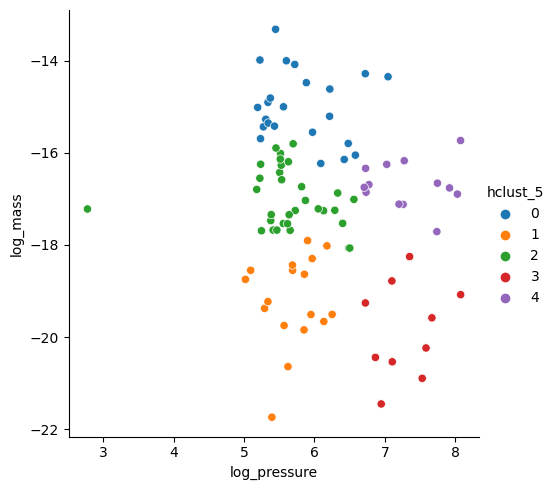

In [70]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_5')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


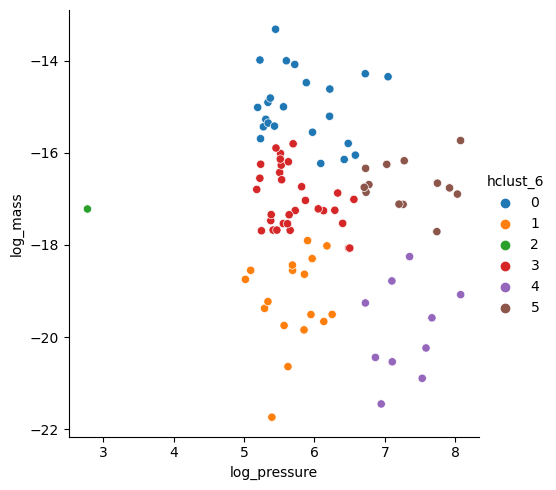

In [71]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_6')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


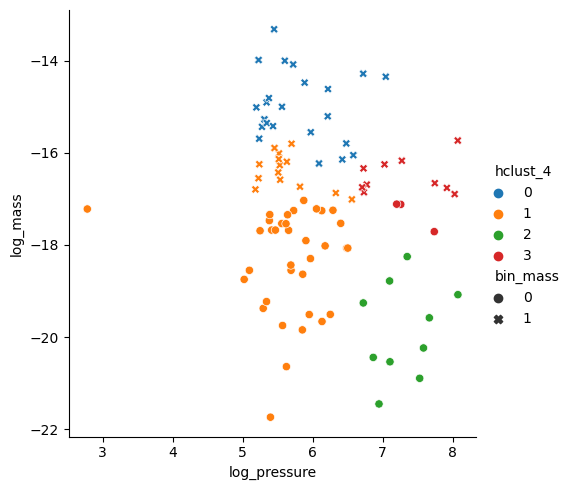

In [72]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_4', style='bin_mass')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


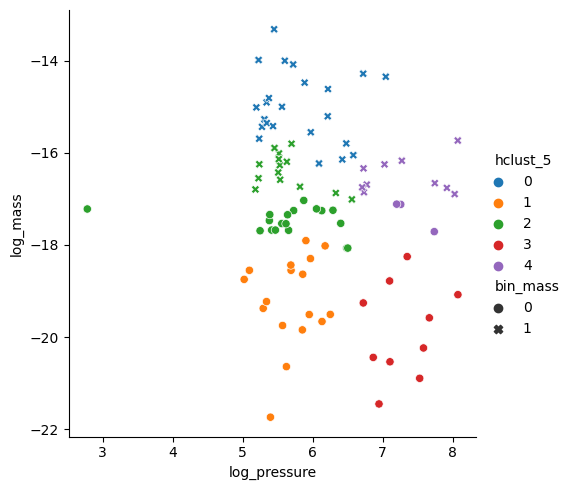

In [73]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_5', style='bin_mass')
plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


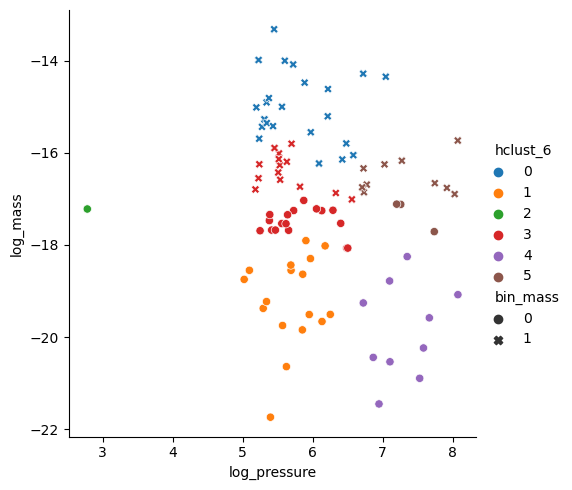

In [74]:
sns.relplot(data = df_copy, x='log_pressure', y='log_mass', hue='hclust_6', style='bin_mass')
plt.show()

In [75]:
lf_copy_h = df_copy.drop(columns=['mass', 'pressure', 'pressure_shift']).copy().\
reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'model', 'log_mass', 'log_pressure', 'bin_mass',
              'hclust_3', 'hclust_4', 'hclust_5', 'hclust_6'], 
     value_vars=['r_barrel', 'r_vortex', 'h_vortex', 'w_inlet', 'h_inlet'], 
     value_name='input_value',
     var_name='input_name',
     ignore_index=True)

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


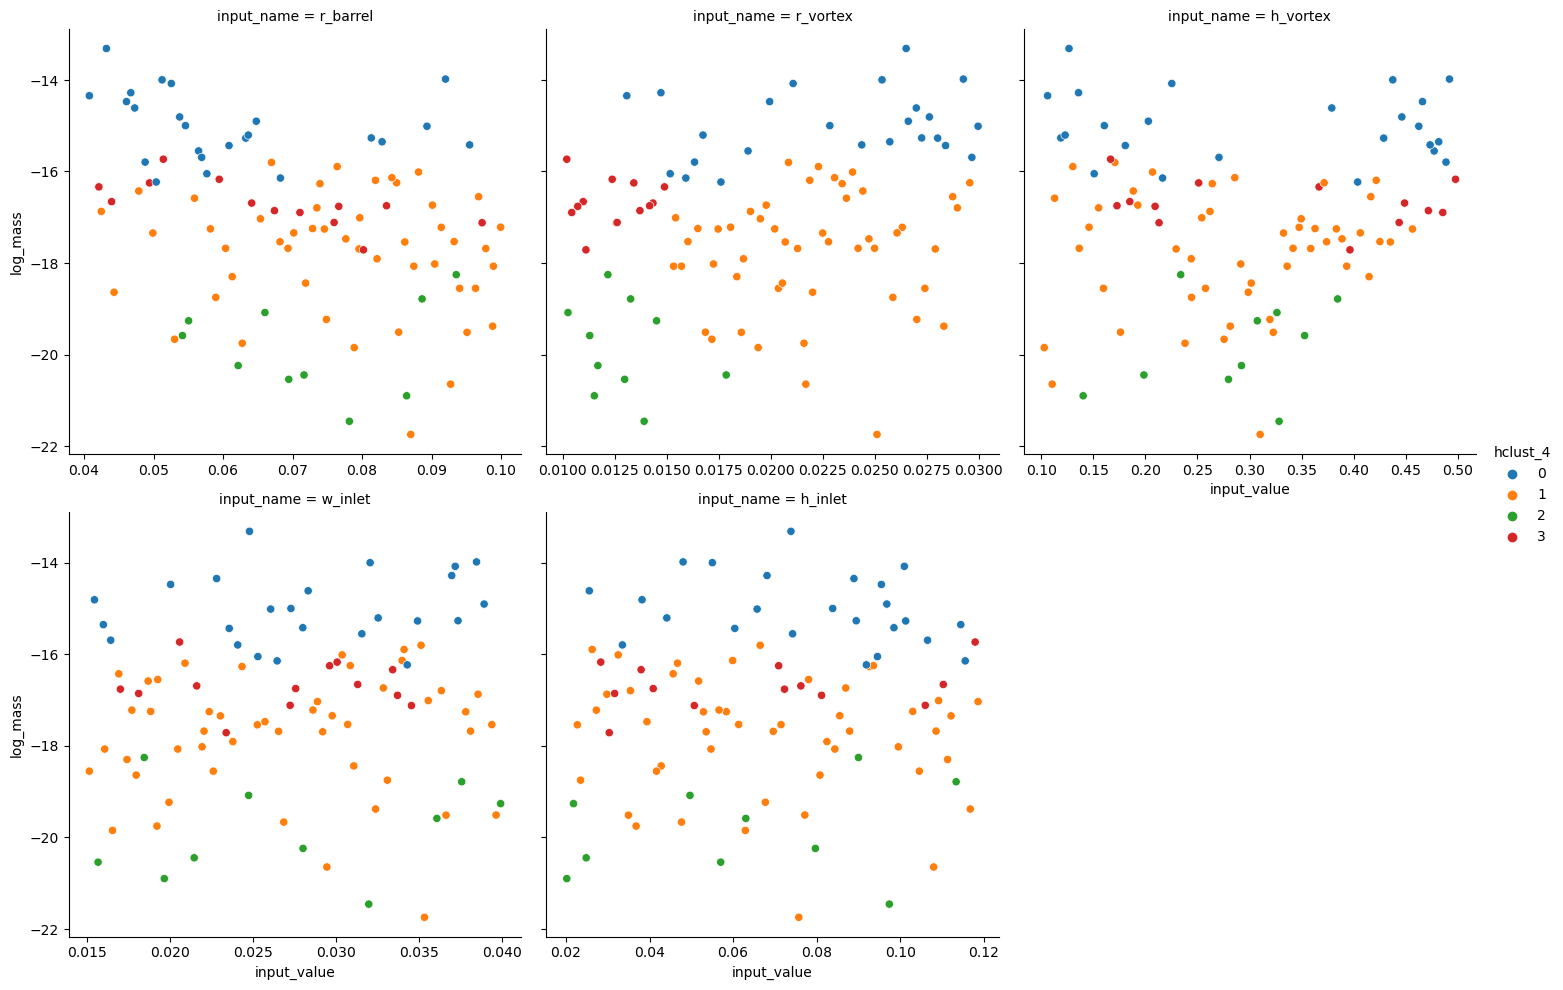

In [76]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_mass', hue='hclust_4', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


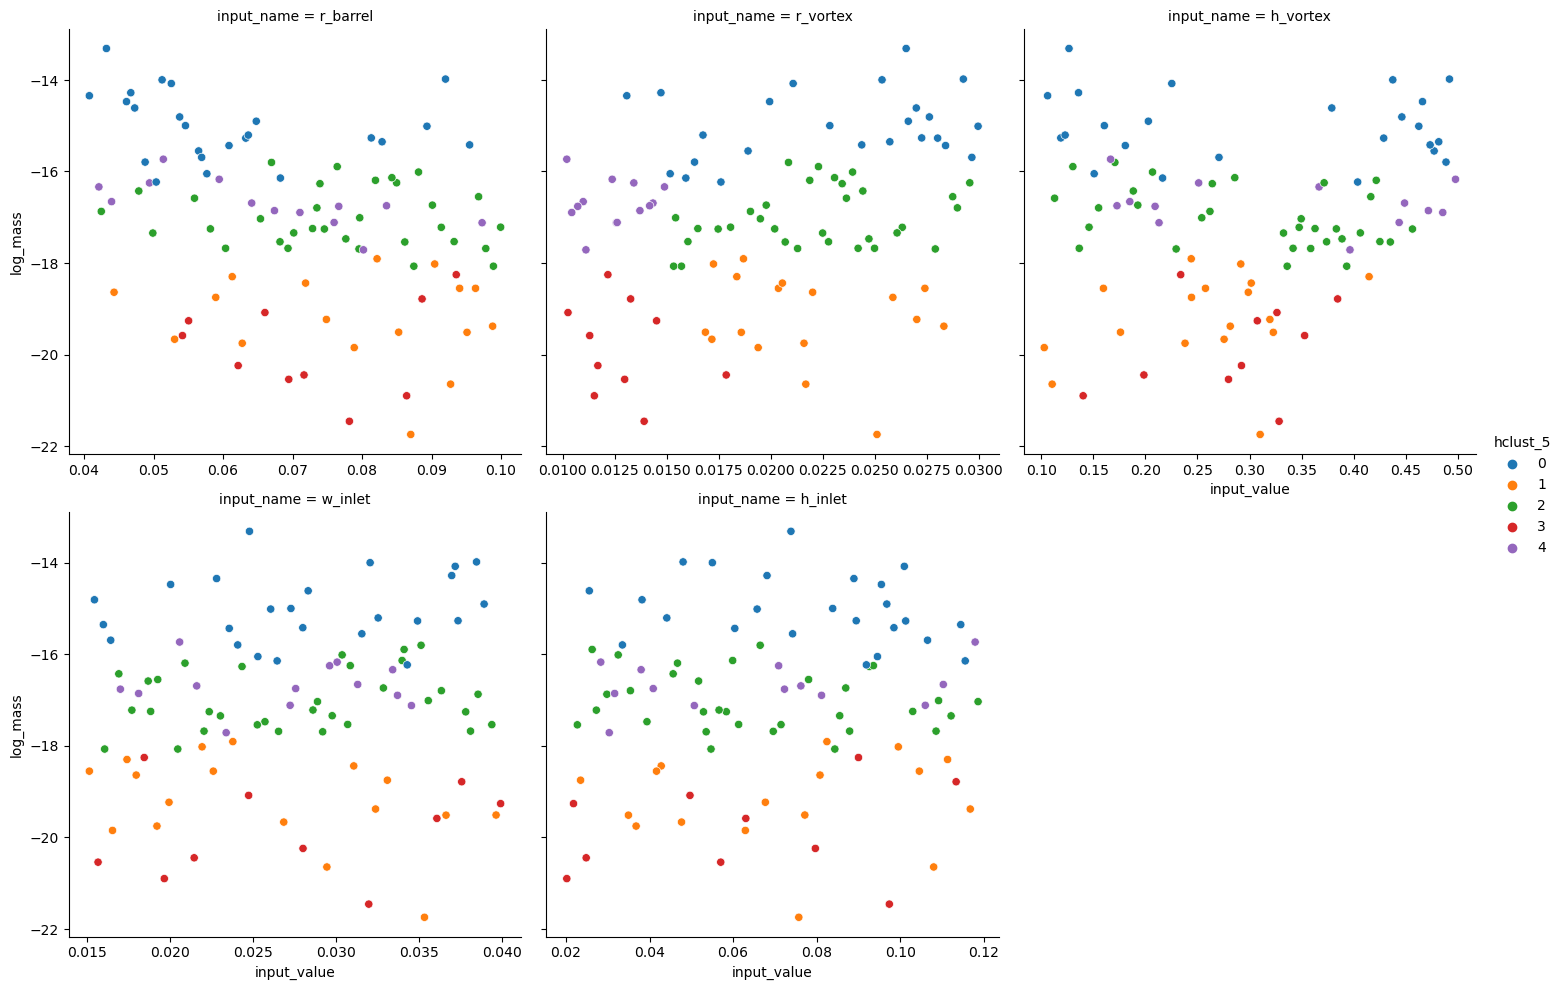

In [77]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_mass', hue='hclust_5', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


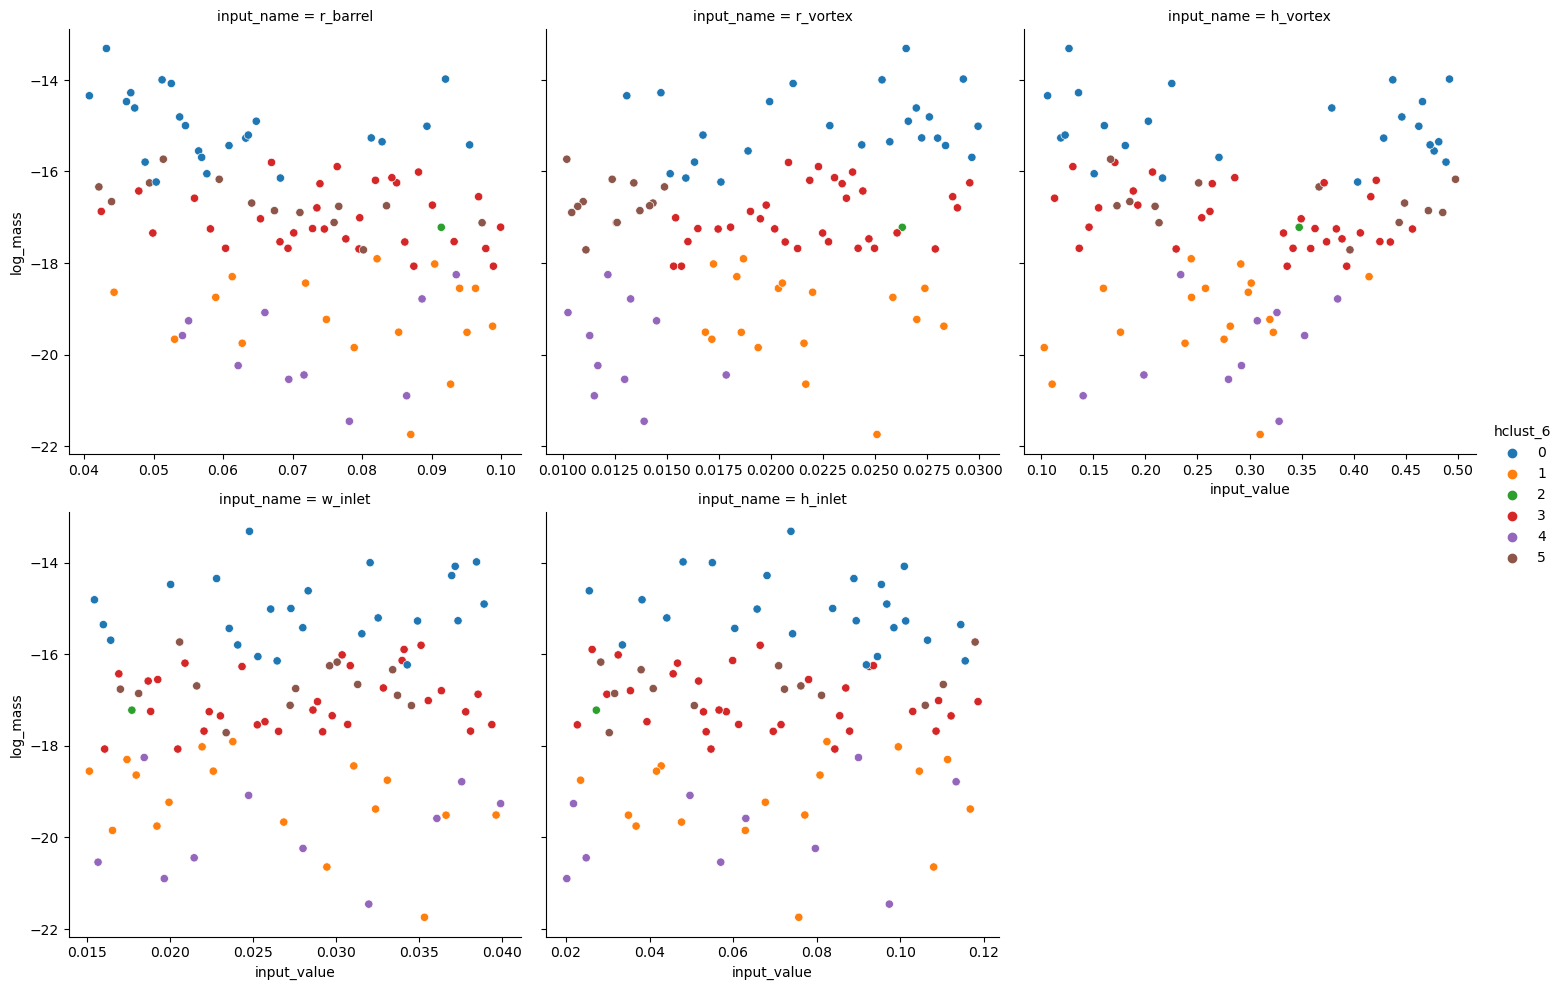

In [78]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_mass', hue='hclust_6', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


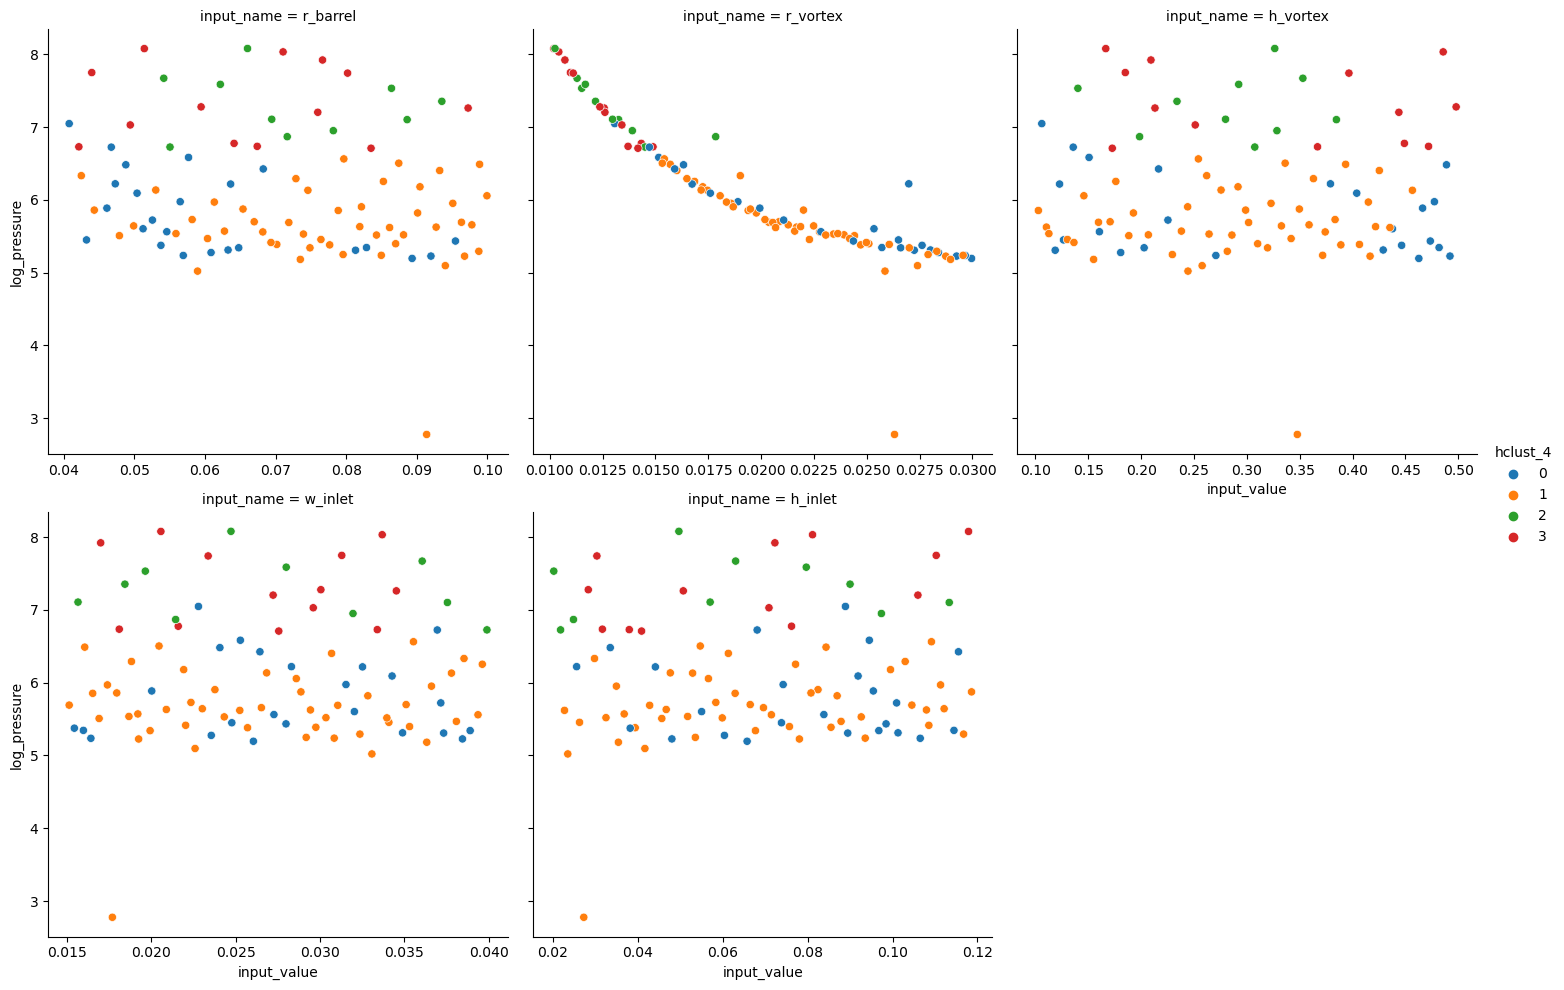

In [79]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_pressure', hue='hclust_4', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


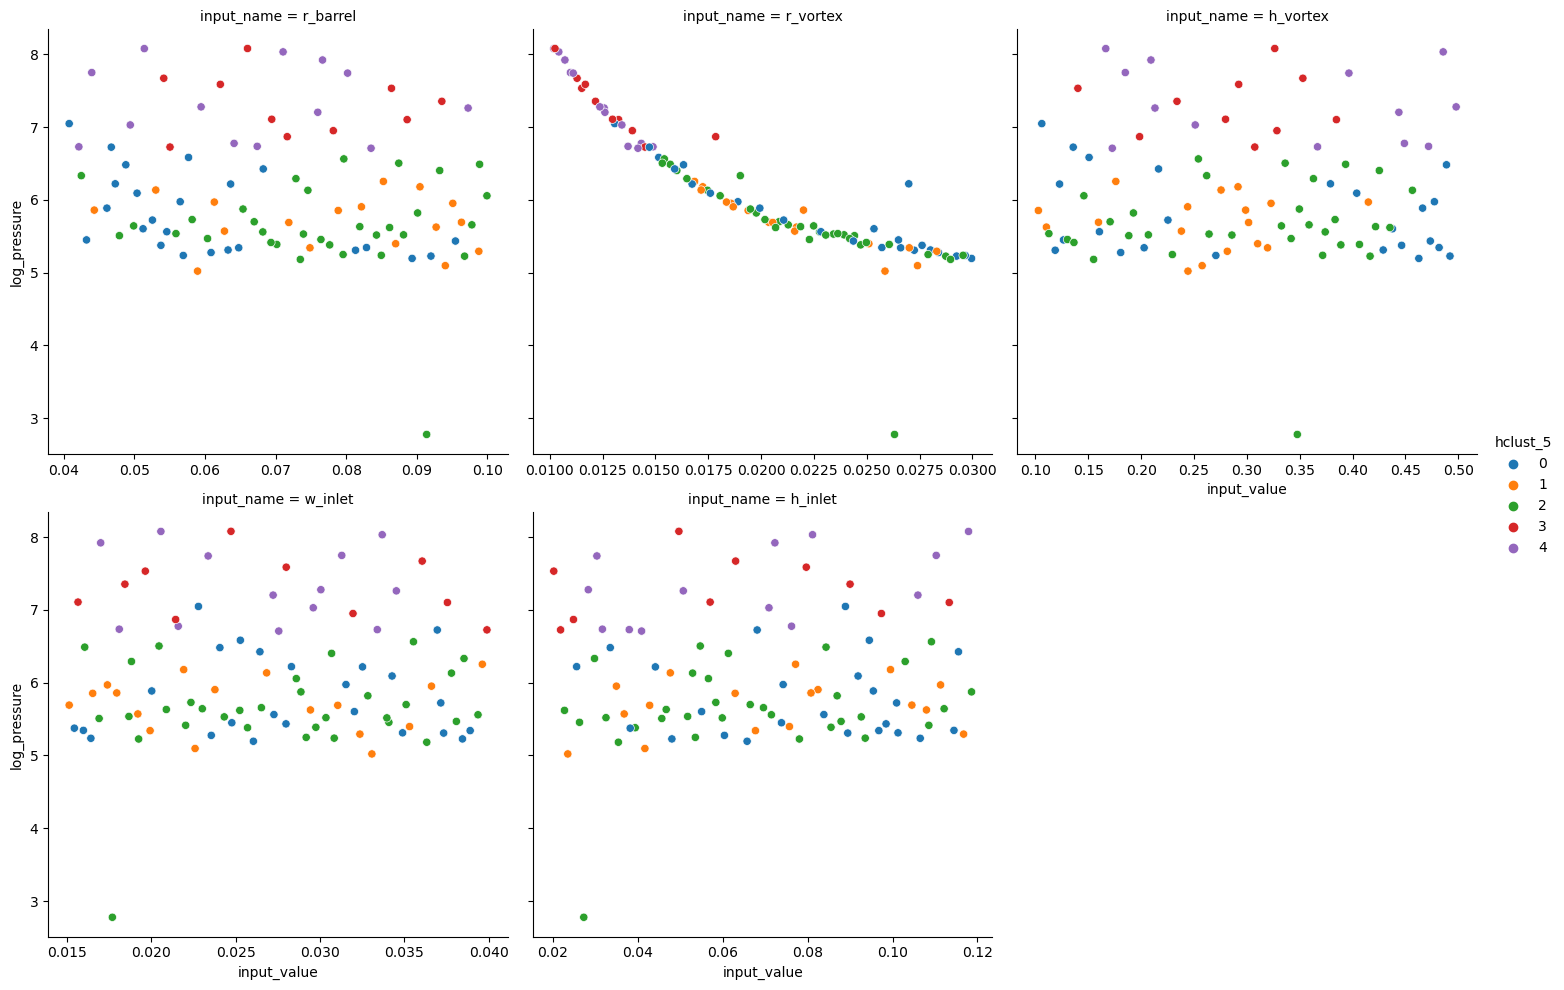

In [80]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_pressure', hue='hclust_5', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


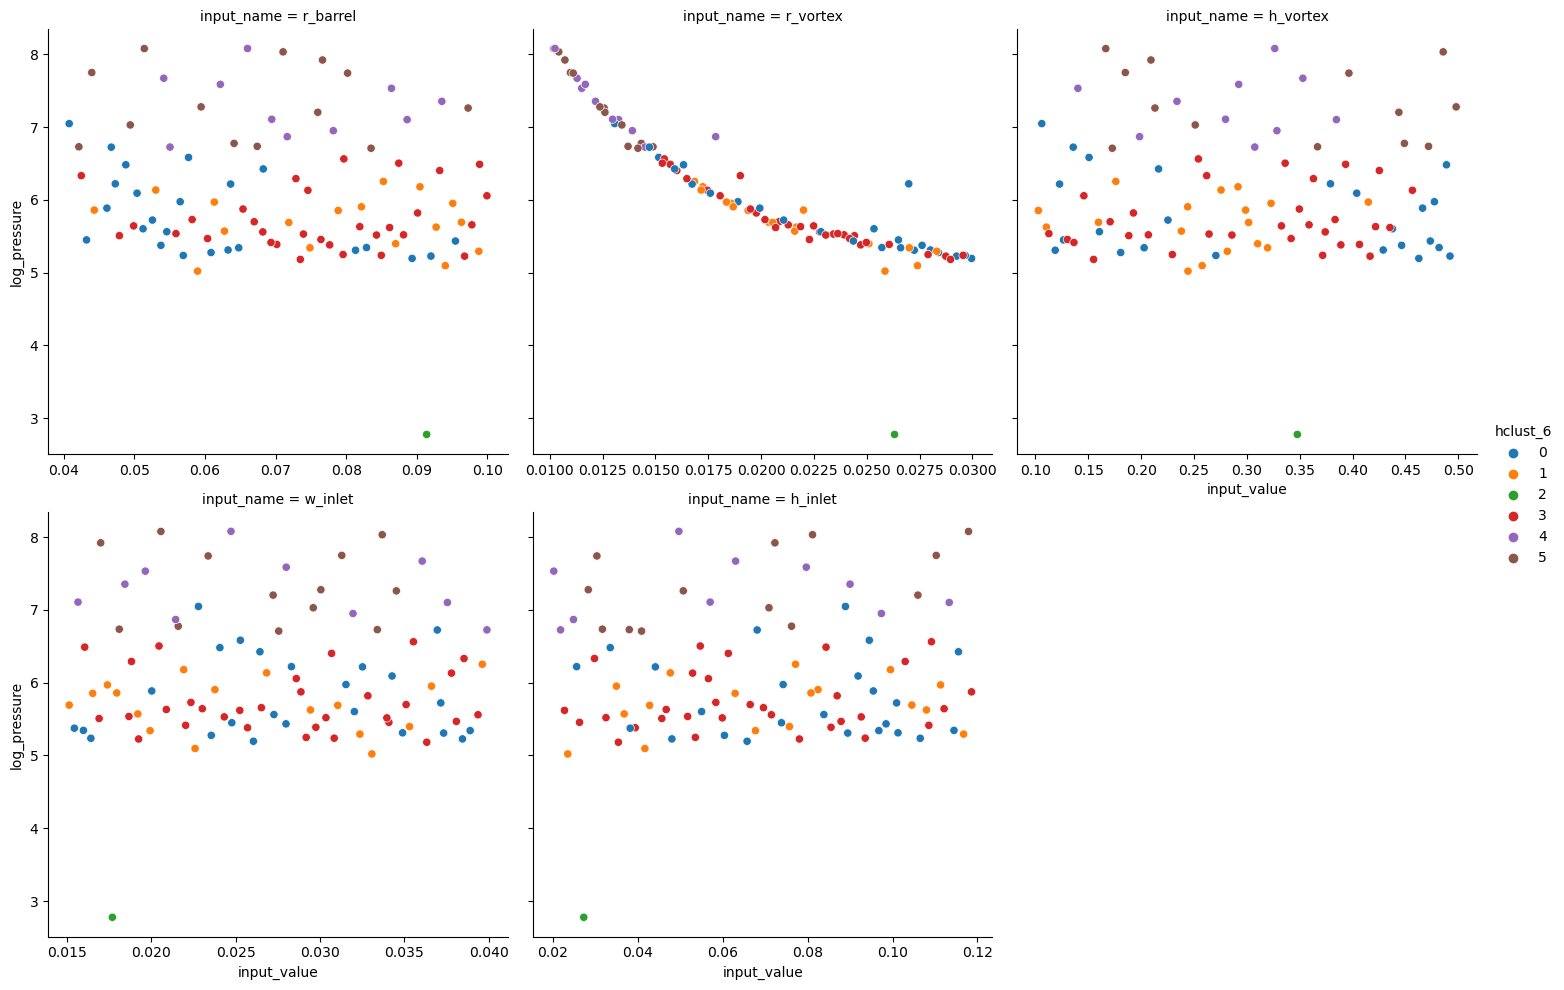

In [81]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_pressure', hue='hclust_6', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


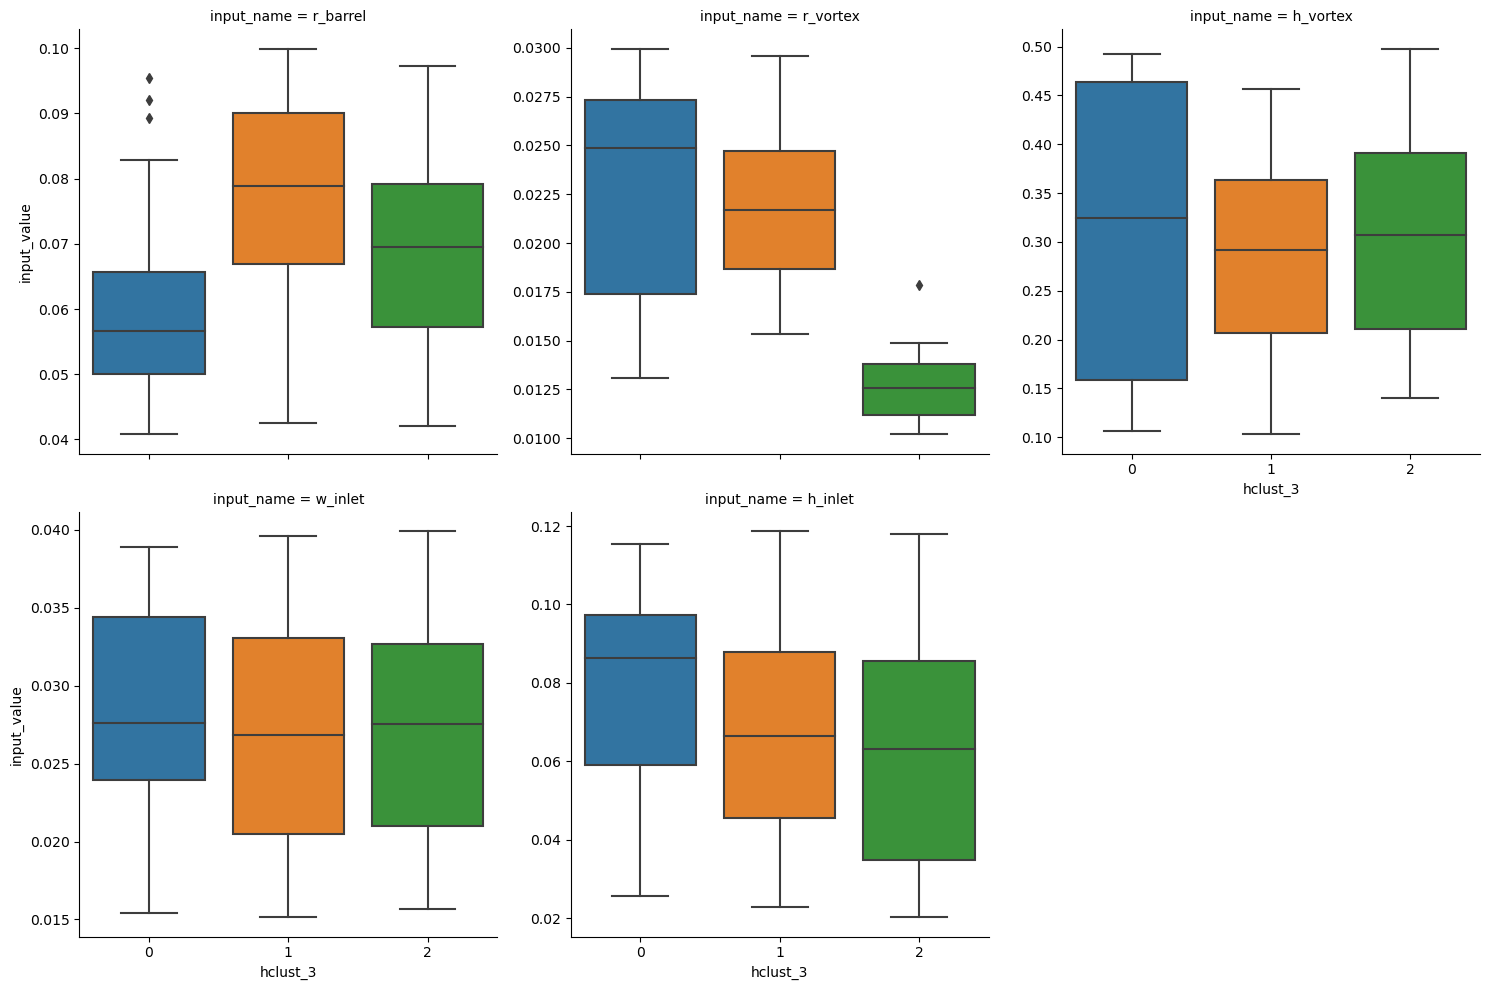

In [84]:
sns.catplot(data = lf_copy_h, x='hclust_3', y='input_value', col='input_name',
            col_wrap=3, kind='box', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


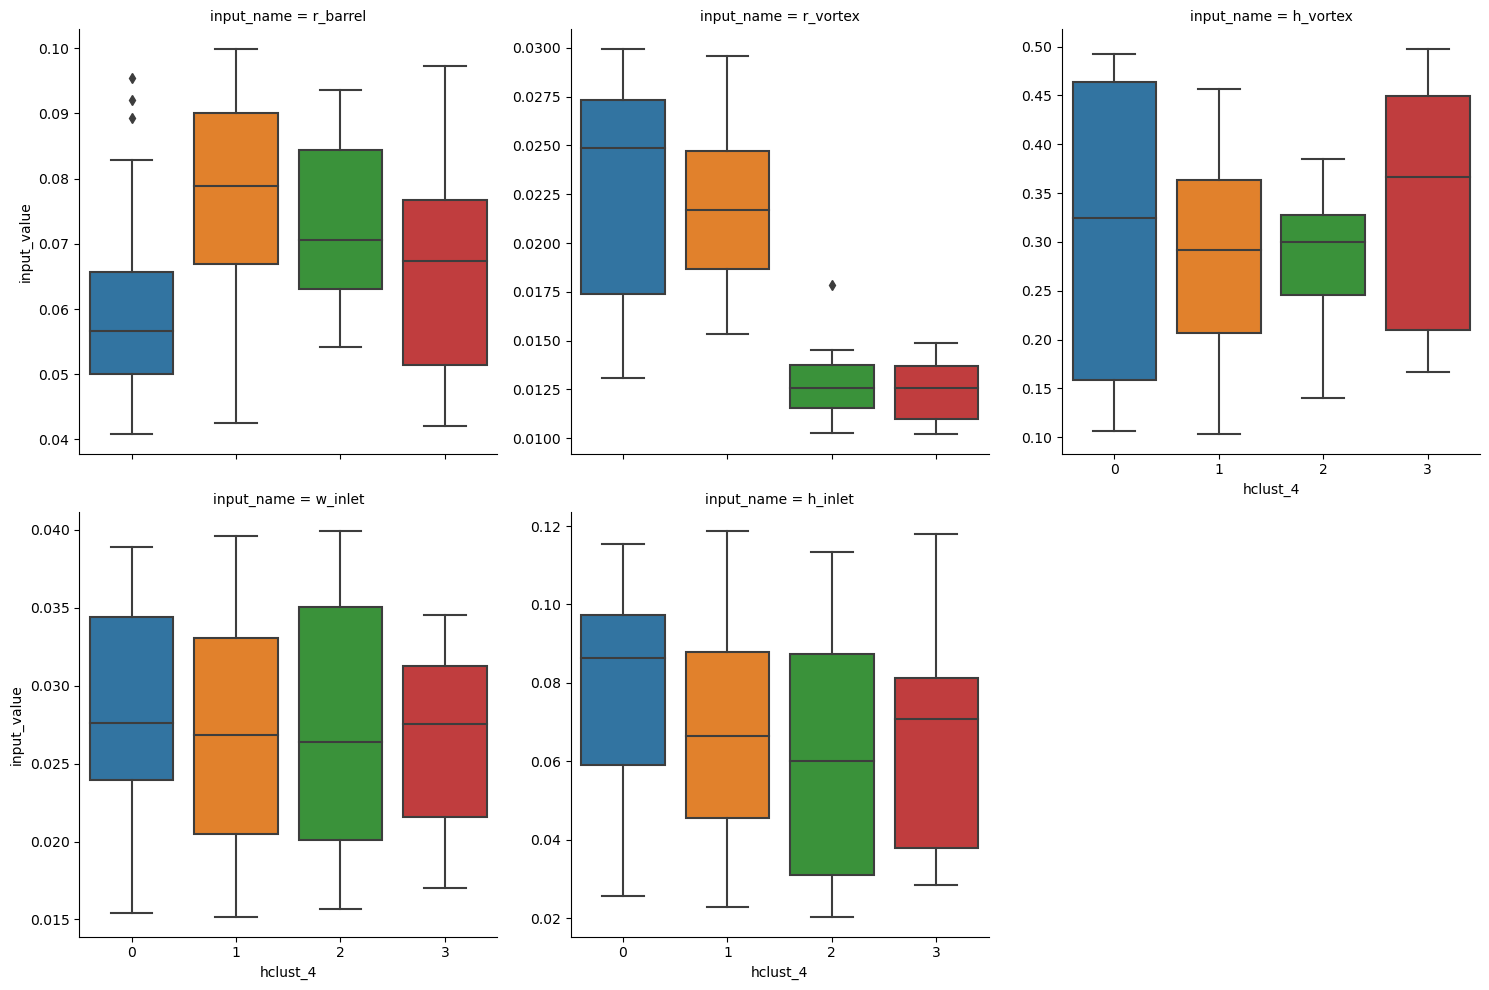

In [85]:
sns.catplot(data = lf_copy_h, x='hclust_4', y='input_value', col='input_name',
            col_wrap=3, kind='box', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


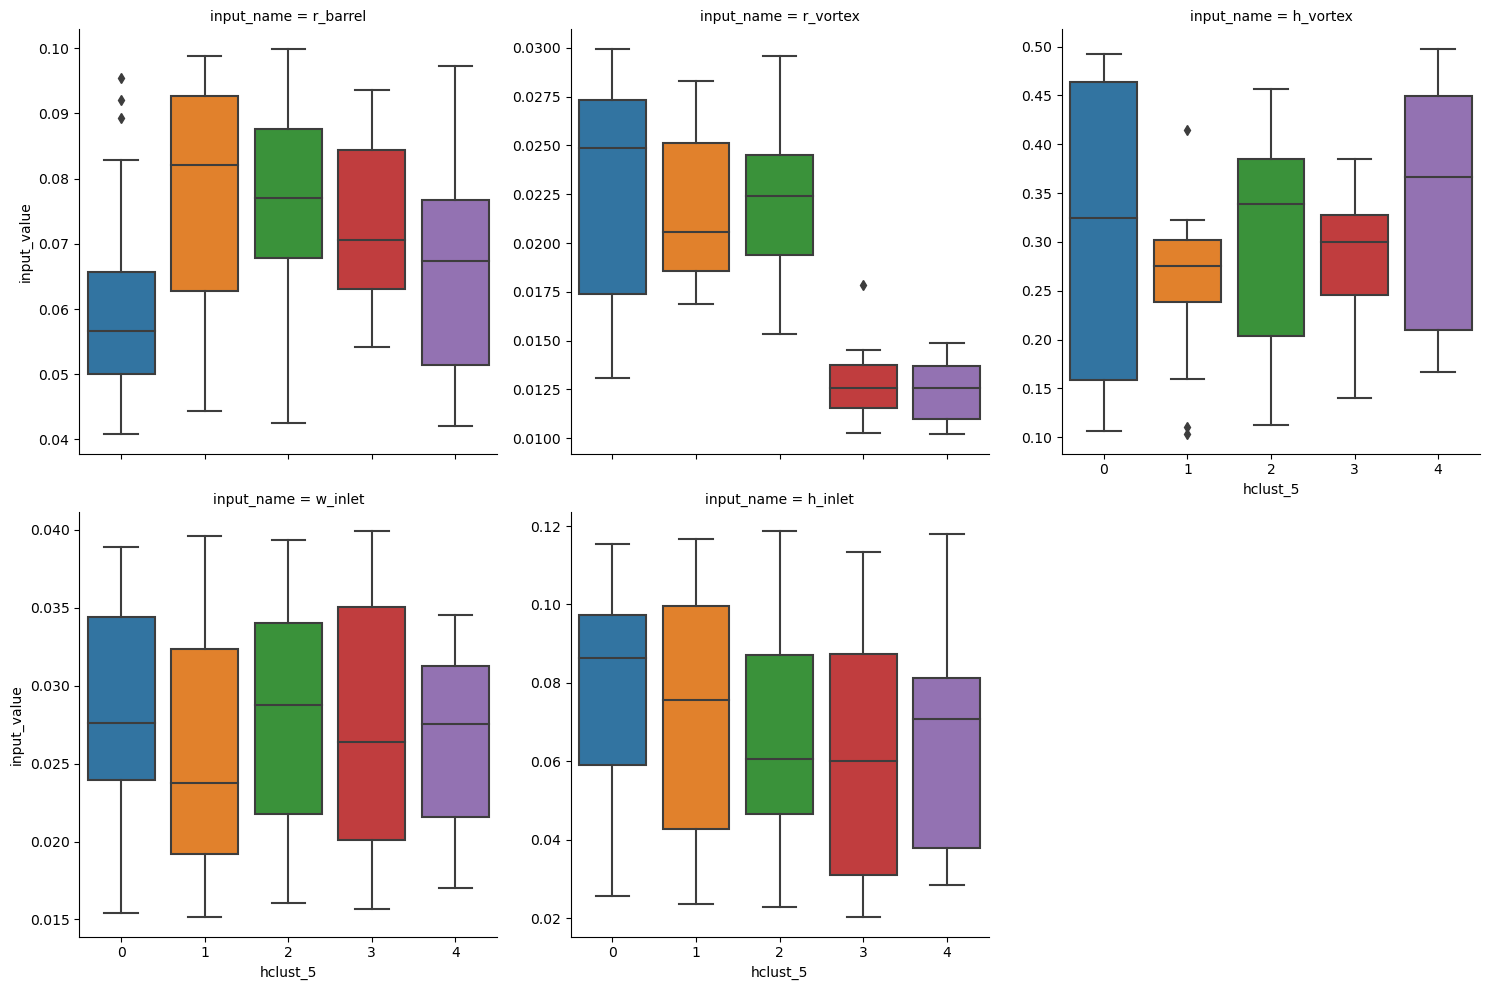

In [86]:
sns.catplot(data = lf_copy_h, x='hclust_5', y='input_value', col='input_name',
            col_wrap=3, kind='box', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


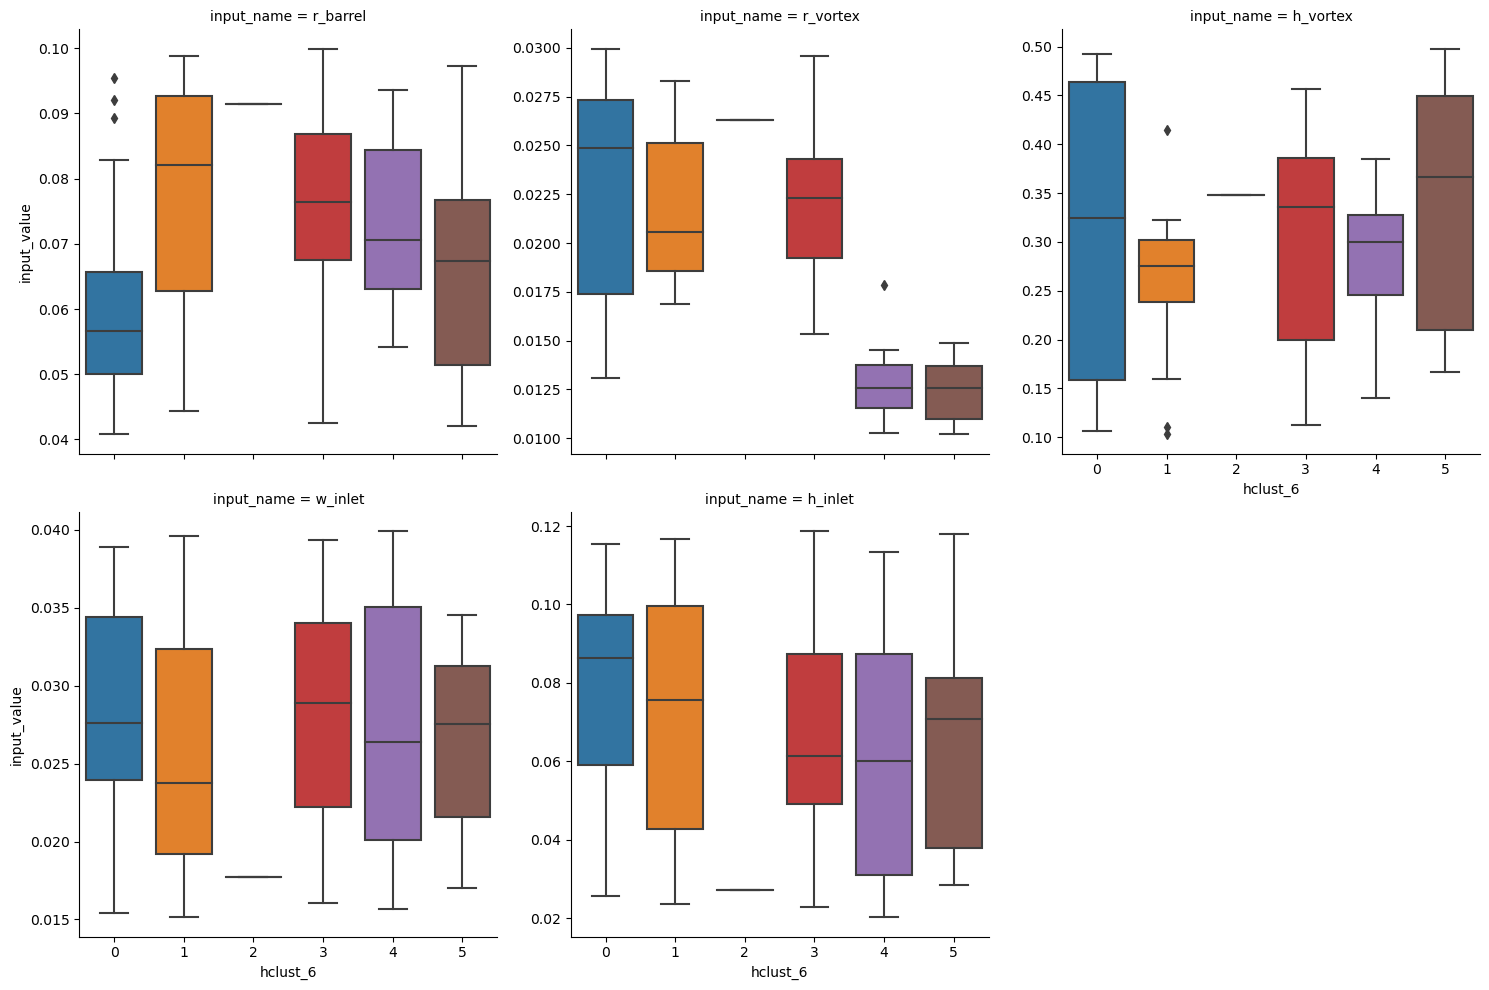

In [87]:
sns.catplot(data = lf_copy_h, x='hclust_6', y='input_value', col='input_name',
            col_wrap=3, kind='box', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


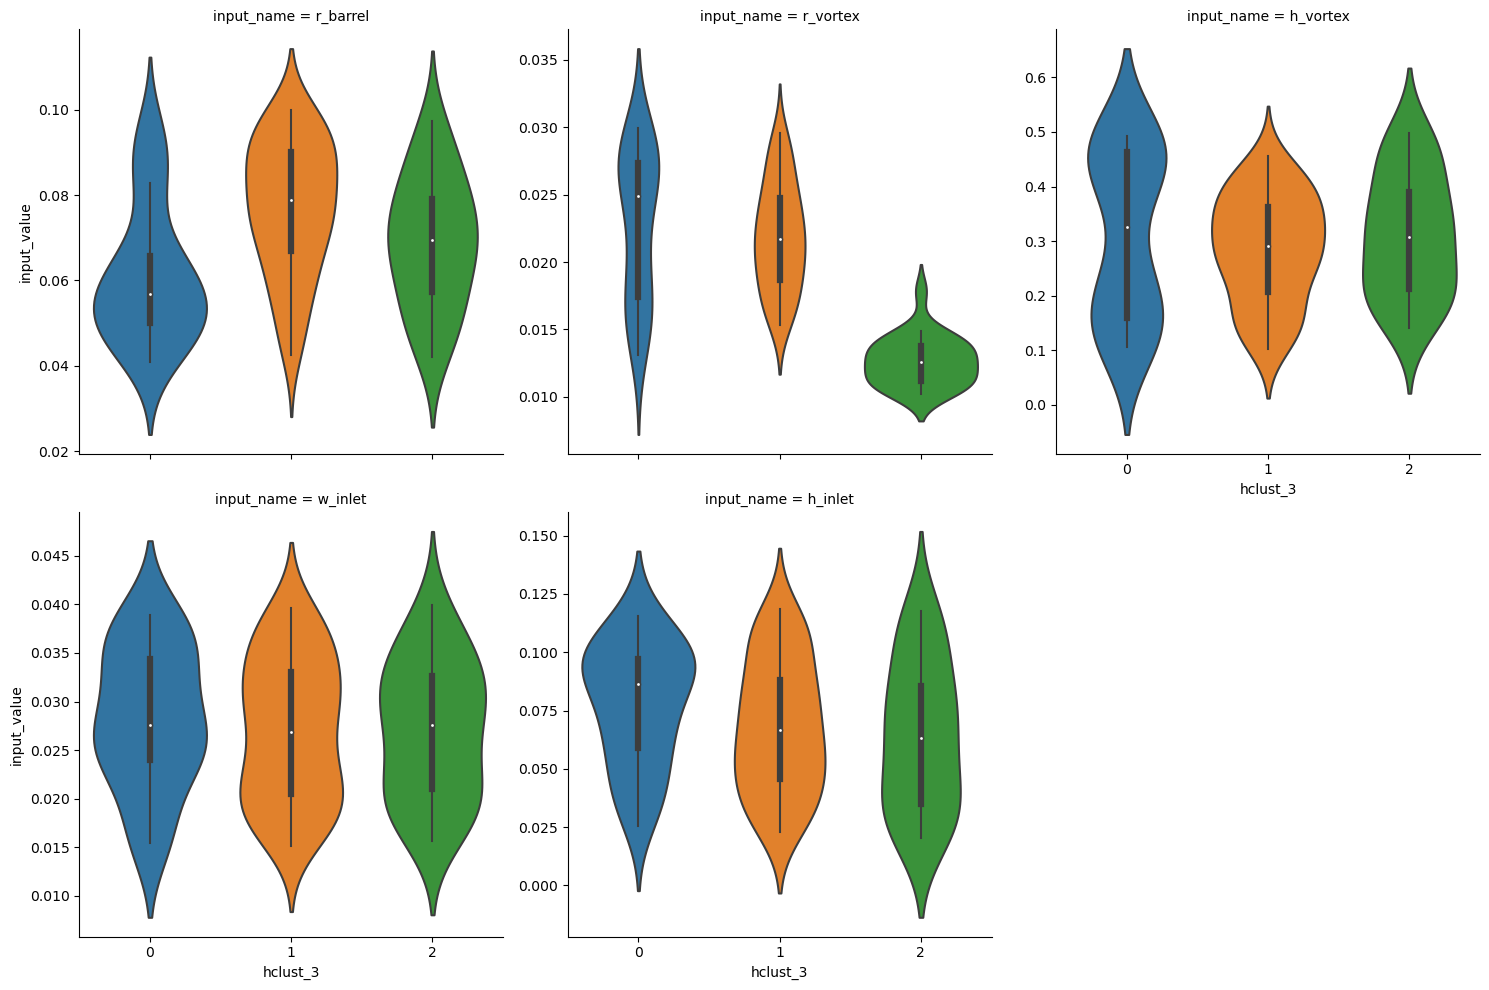

In [88]:
sns.catplot(data = lf_copy_h, x='hclust_3', y='input_value', col='input_name',
            col_wrap=3, kind='violin', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


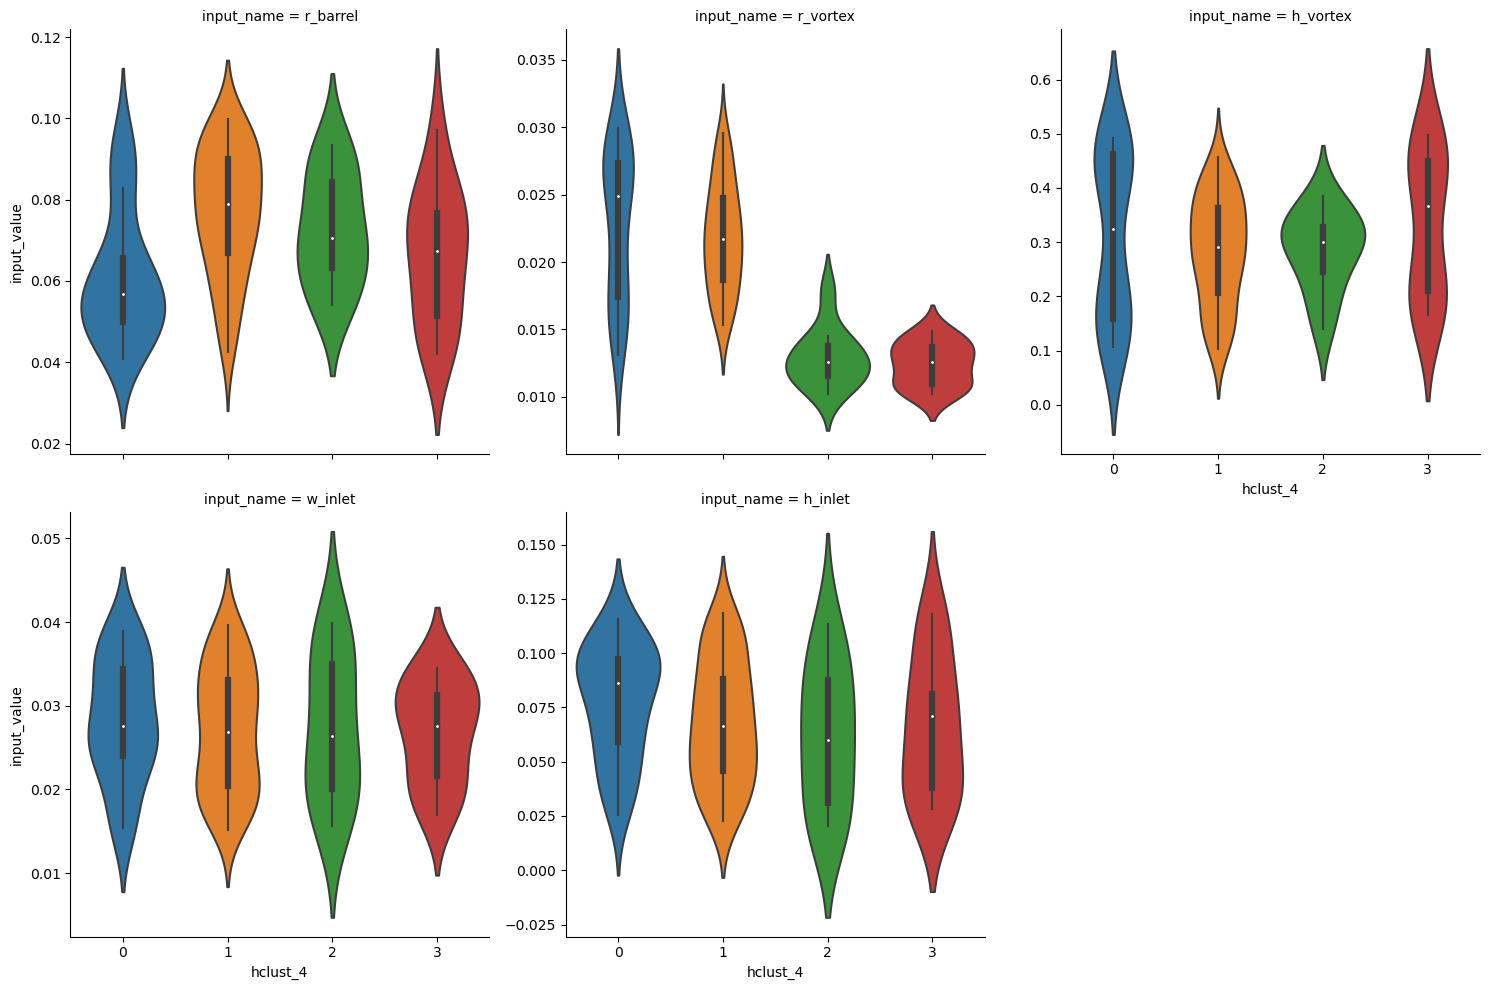

In [89]:
sns.catplot(data = lf_copy_h, x='hclust_4', y='input_value', col='input_name',
            col_wrap=3, kind='violin', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


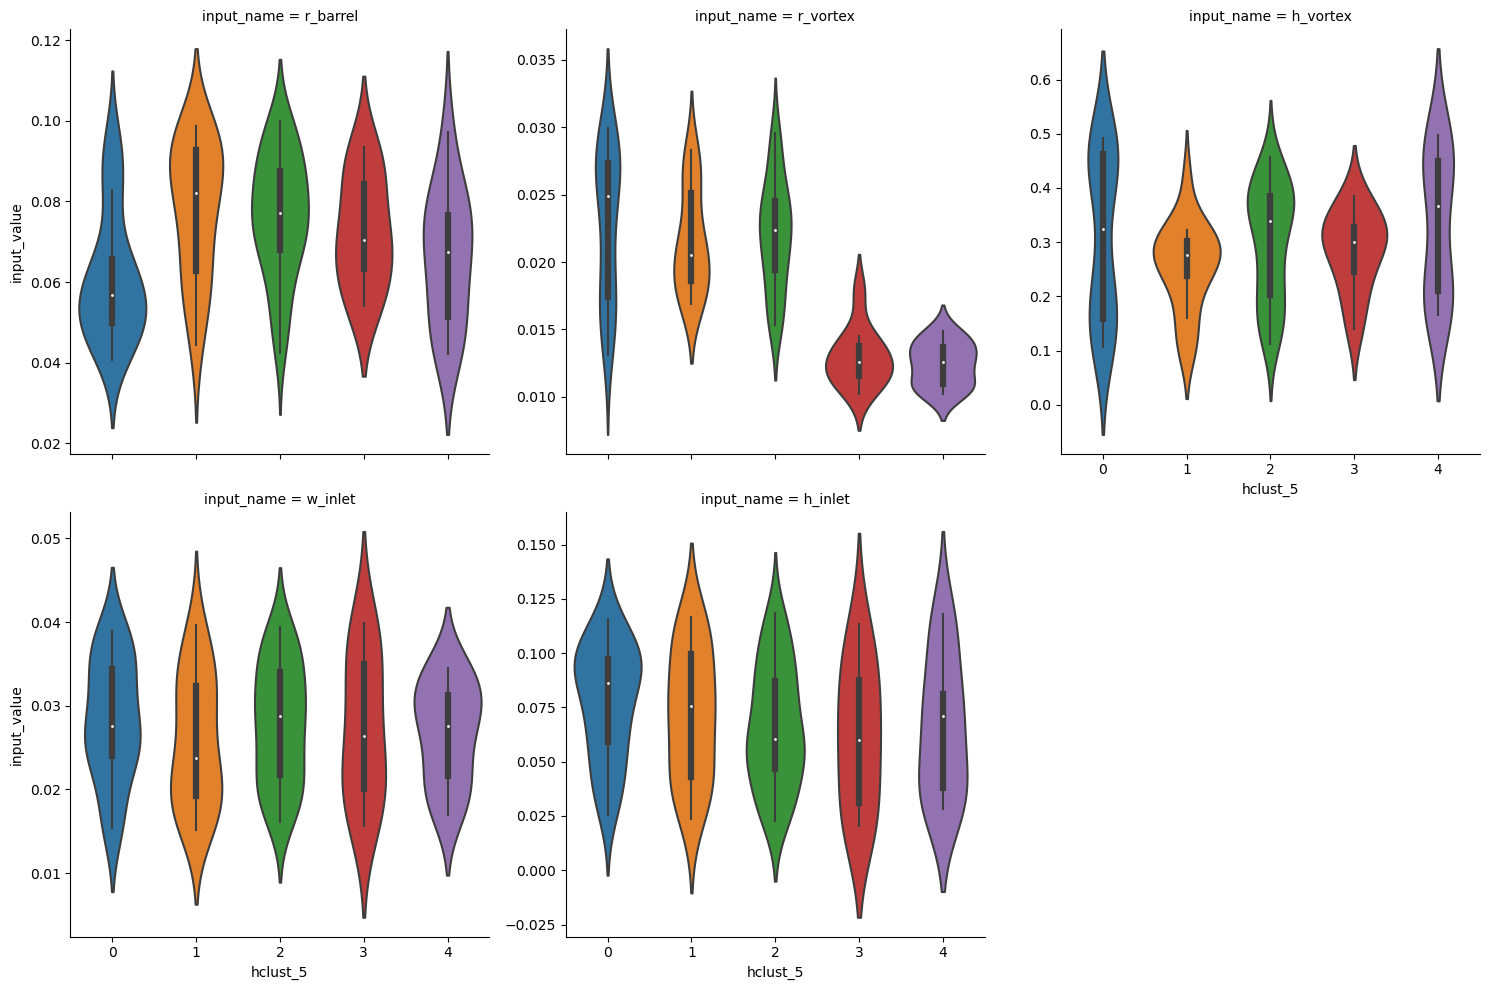

In [90]:
sns.catplot(data = lf_copy_h, x='hclust_5', y='input_value', col='input_name',
            col_wrap=3, kind='violin', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


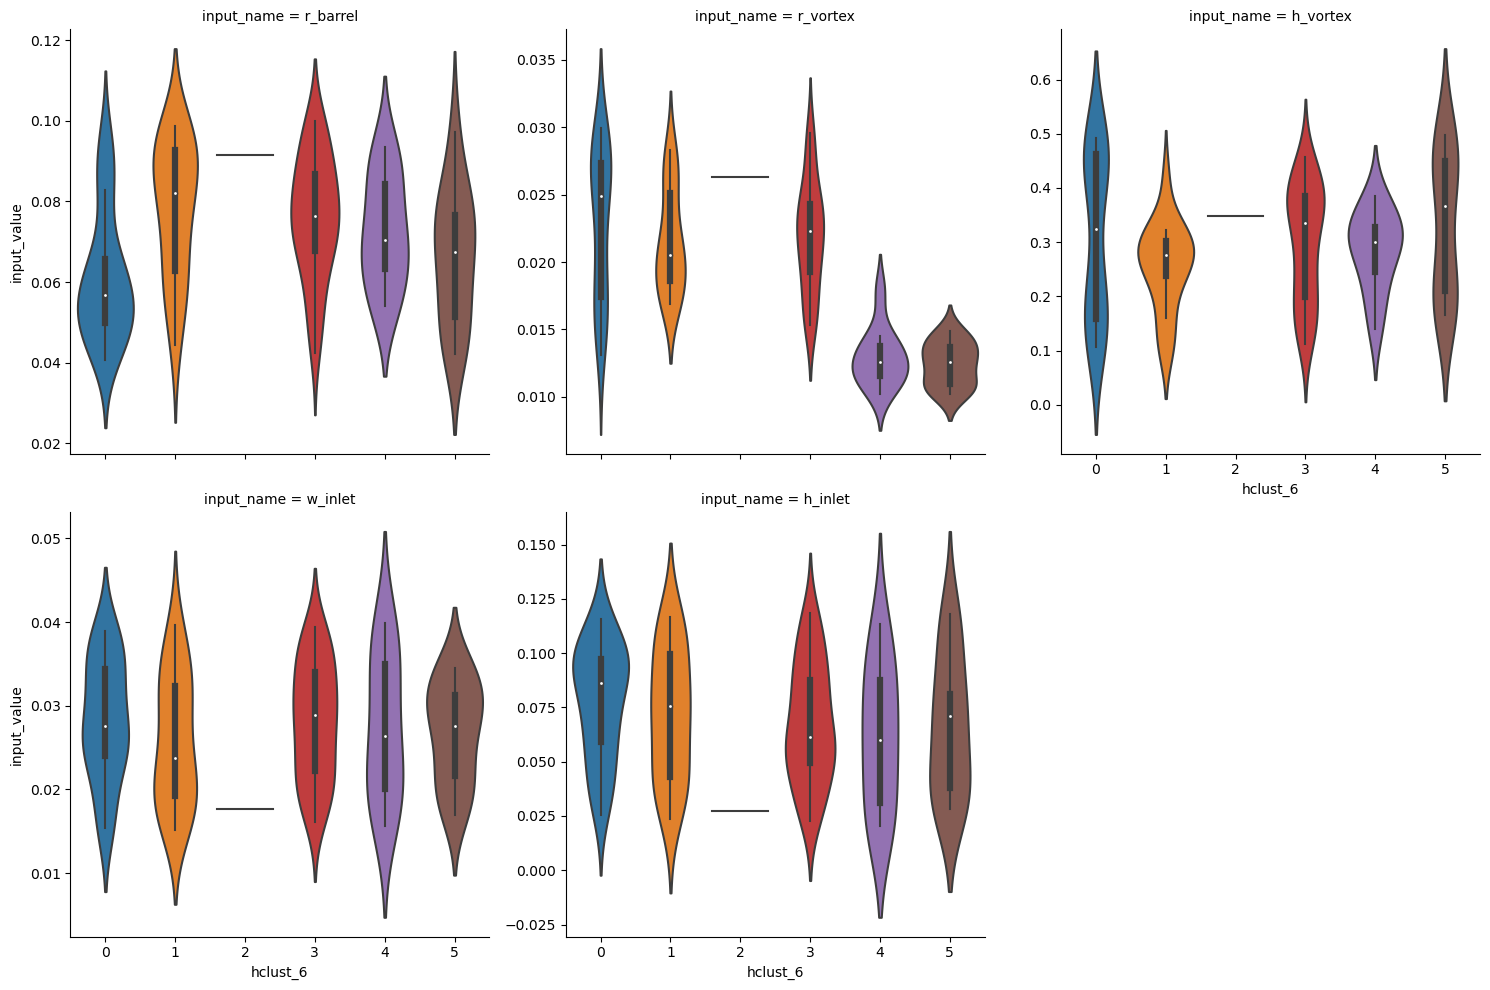

In [91]:
sns.catplot(data = lf_copy_h, x='hclust_6', y='input_value', col='input_name',
            col_wrap=3, kind='violin', sharey=False)

plt.show()

### kmeans 6 vs hclust 3

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


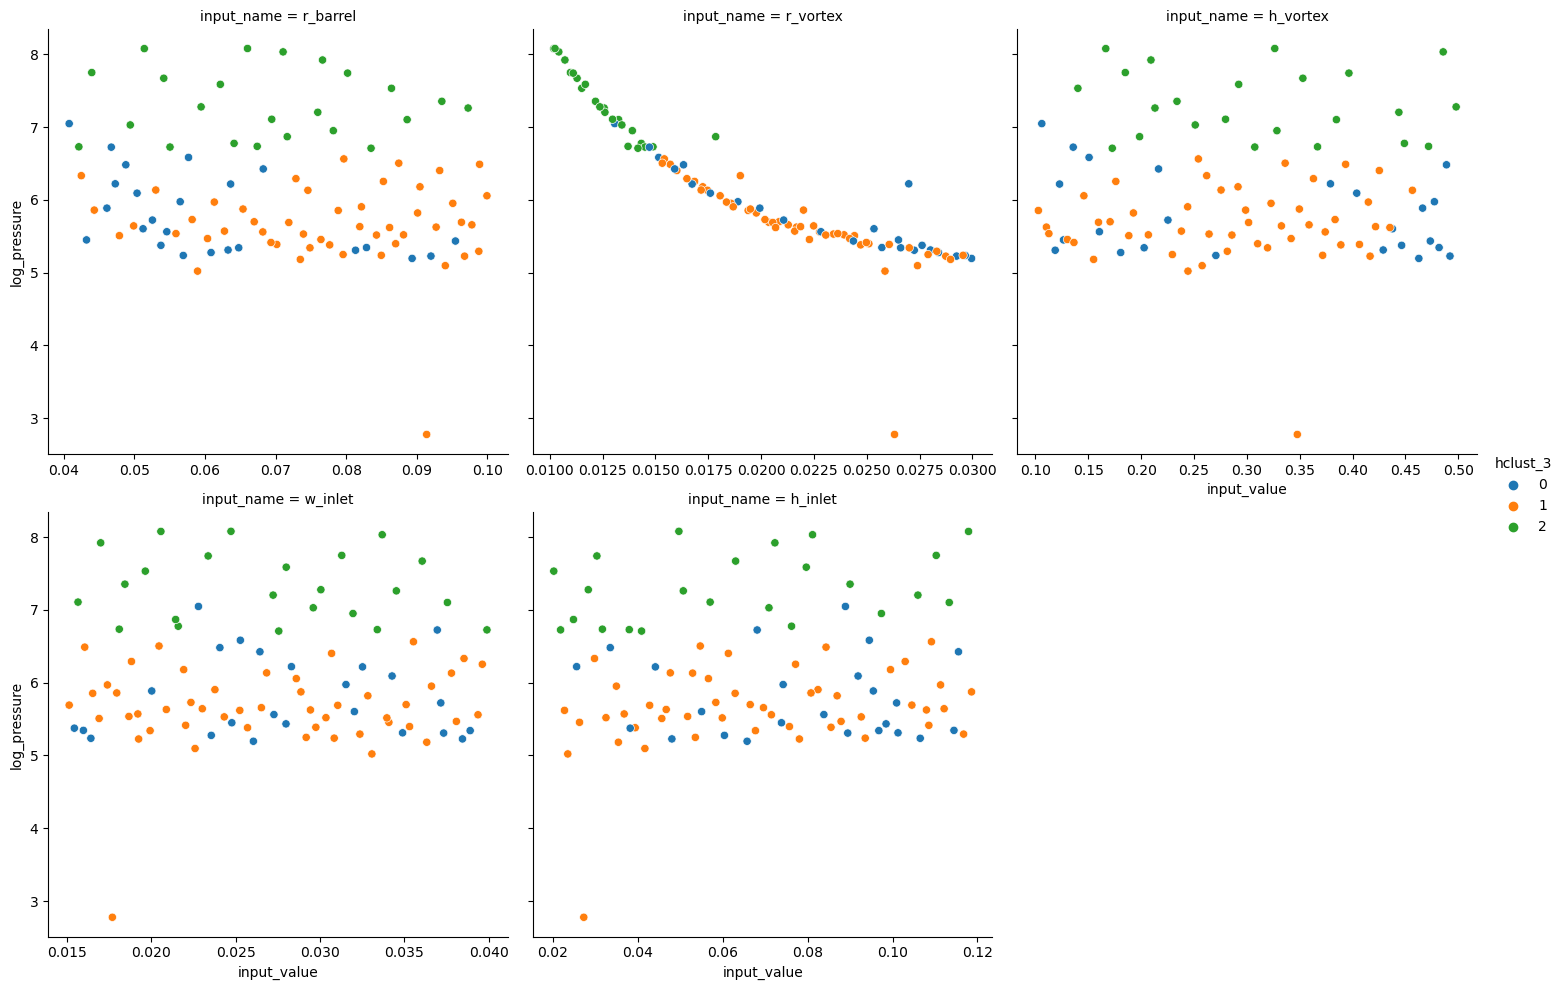

In [92]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_pressure', hue='hclust_3', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


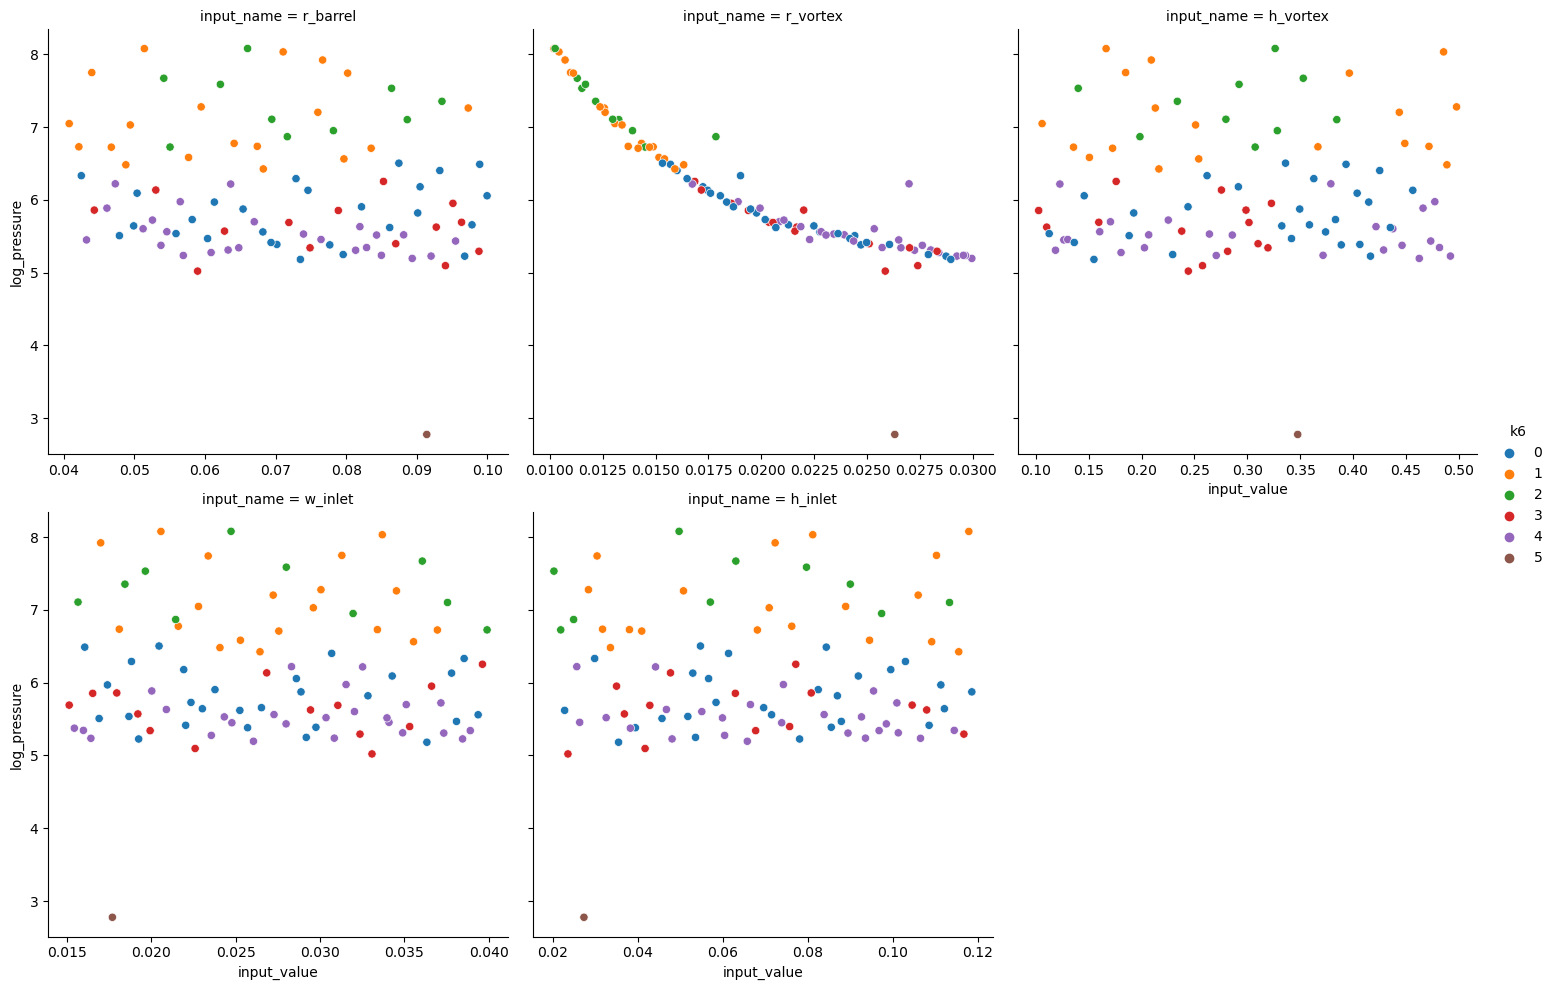

In [95]:
sns.relplot(data = lf_copy, x='input_value', y='log_pressure', hue='k6', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


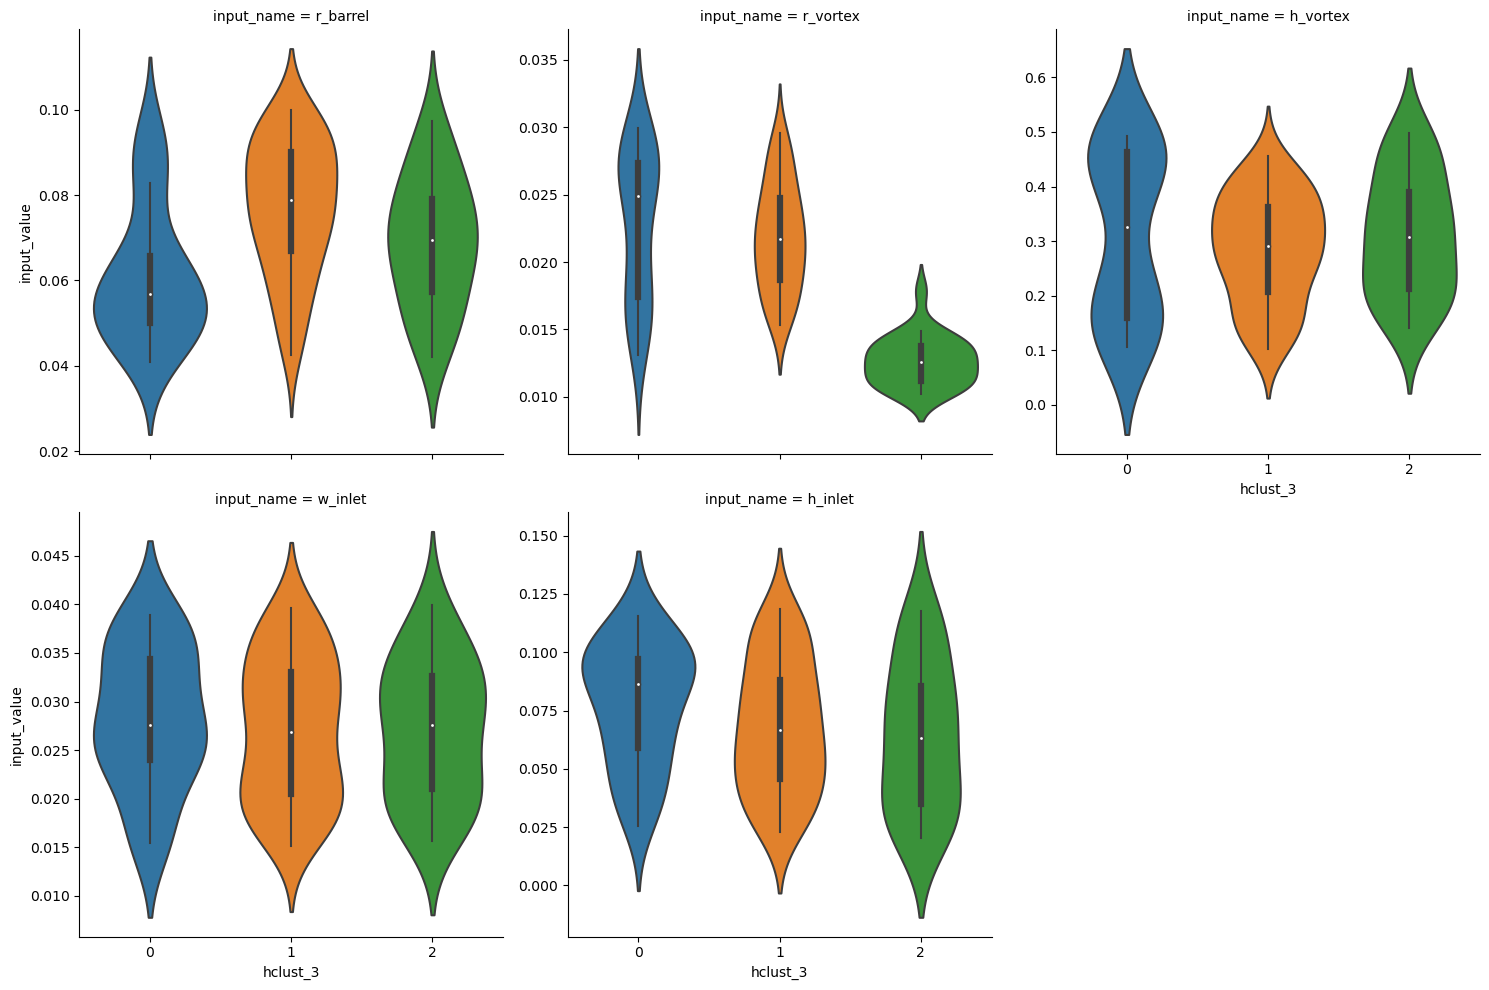

In [96]:
sns.catplot(data = lf_copy_h, x='hclust_3', y='input_value', col='input_name',
            col_wrap=3, kind='violin', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


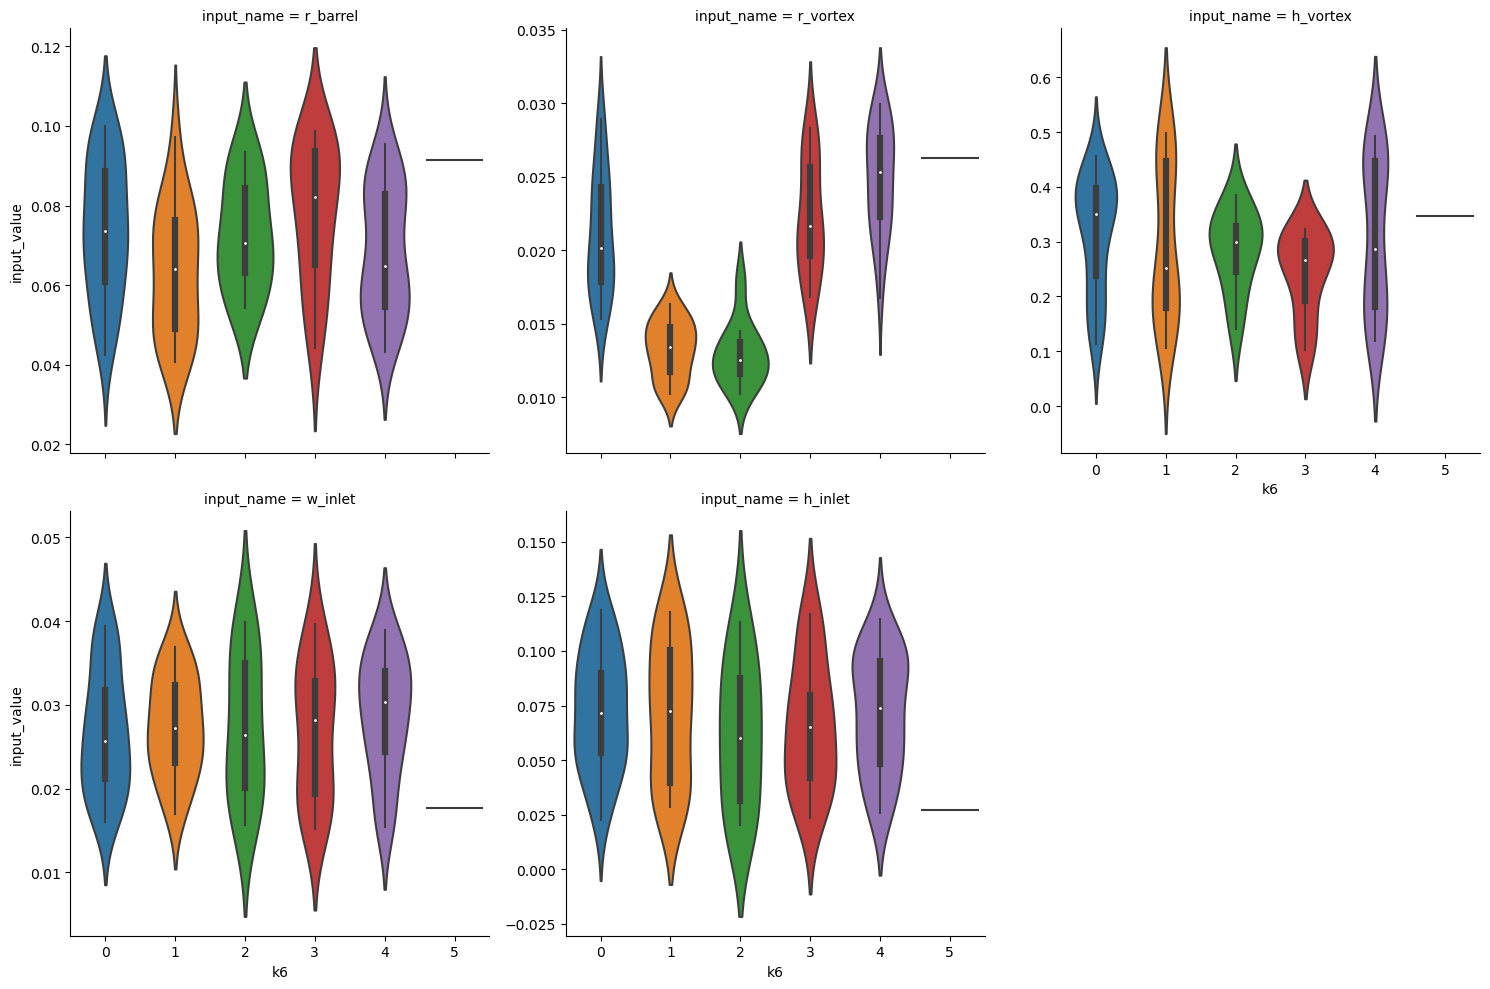

In [97]:
sns.catplot(data = lf_copy, x='k6', y='input_value', col='input_name',
            col_wrap=3, kind='violin', sharey=False)

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


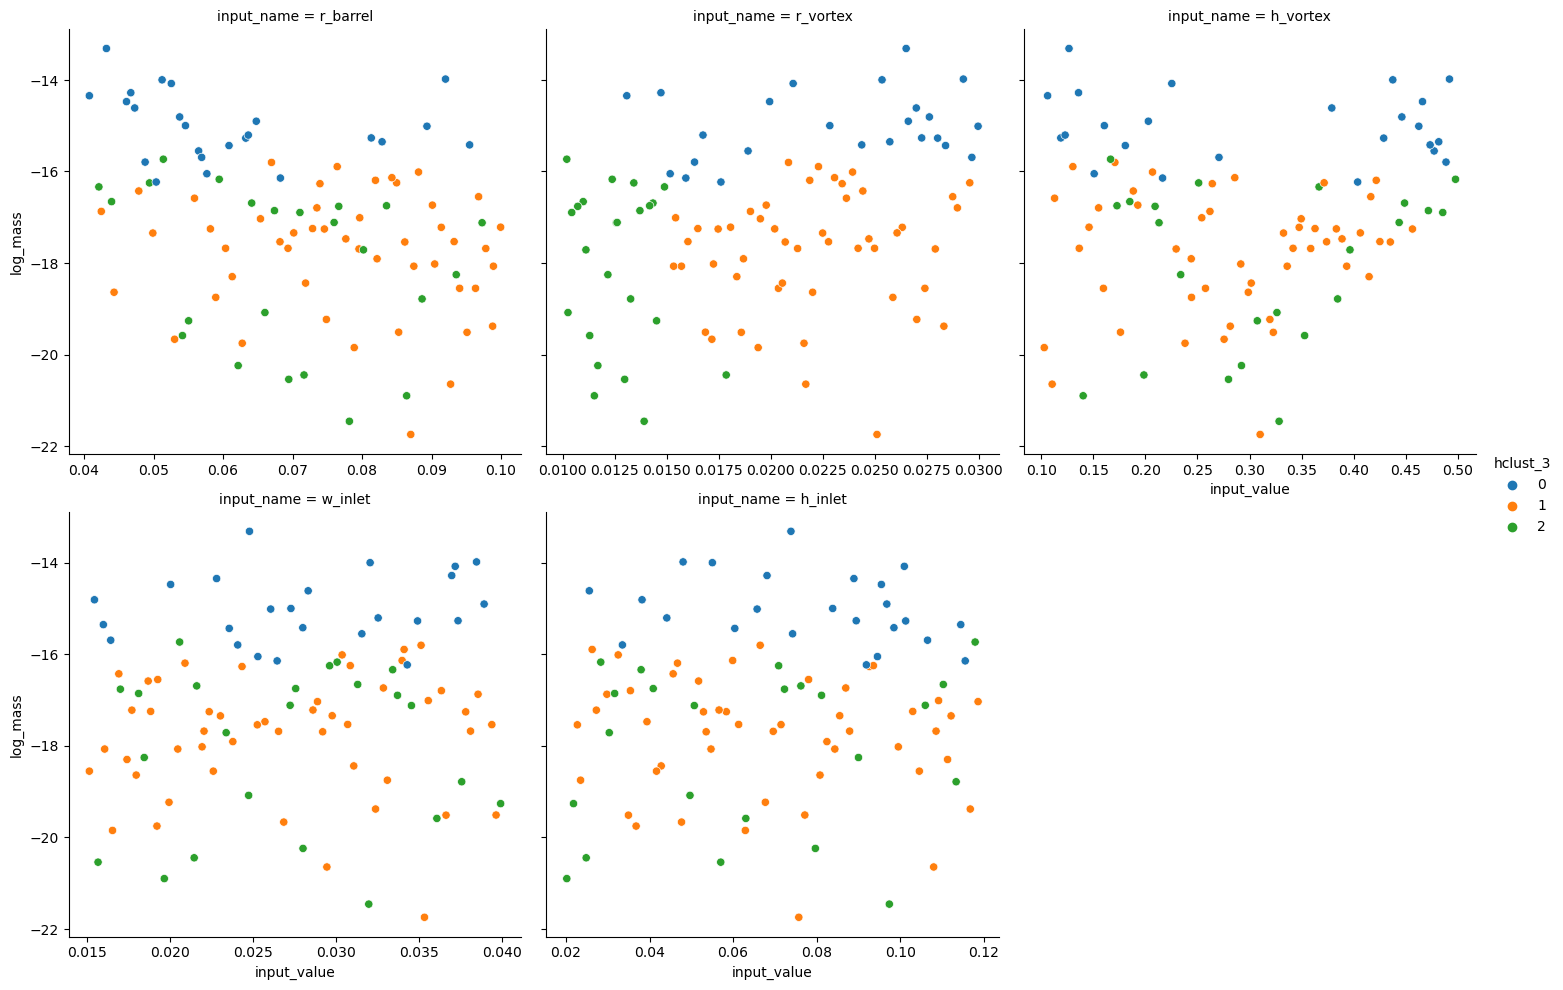

In [98]:
sns.relplot(data = lf_copy_h, x='input_value', y='log_mass', hue='hclust_3', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


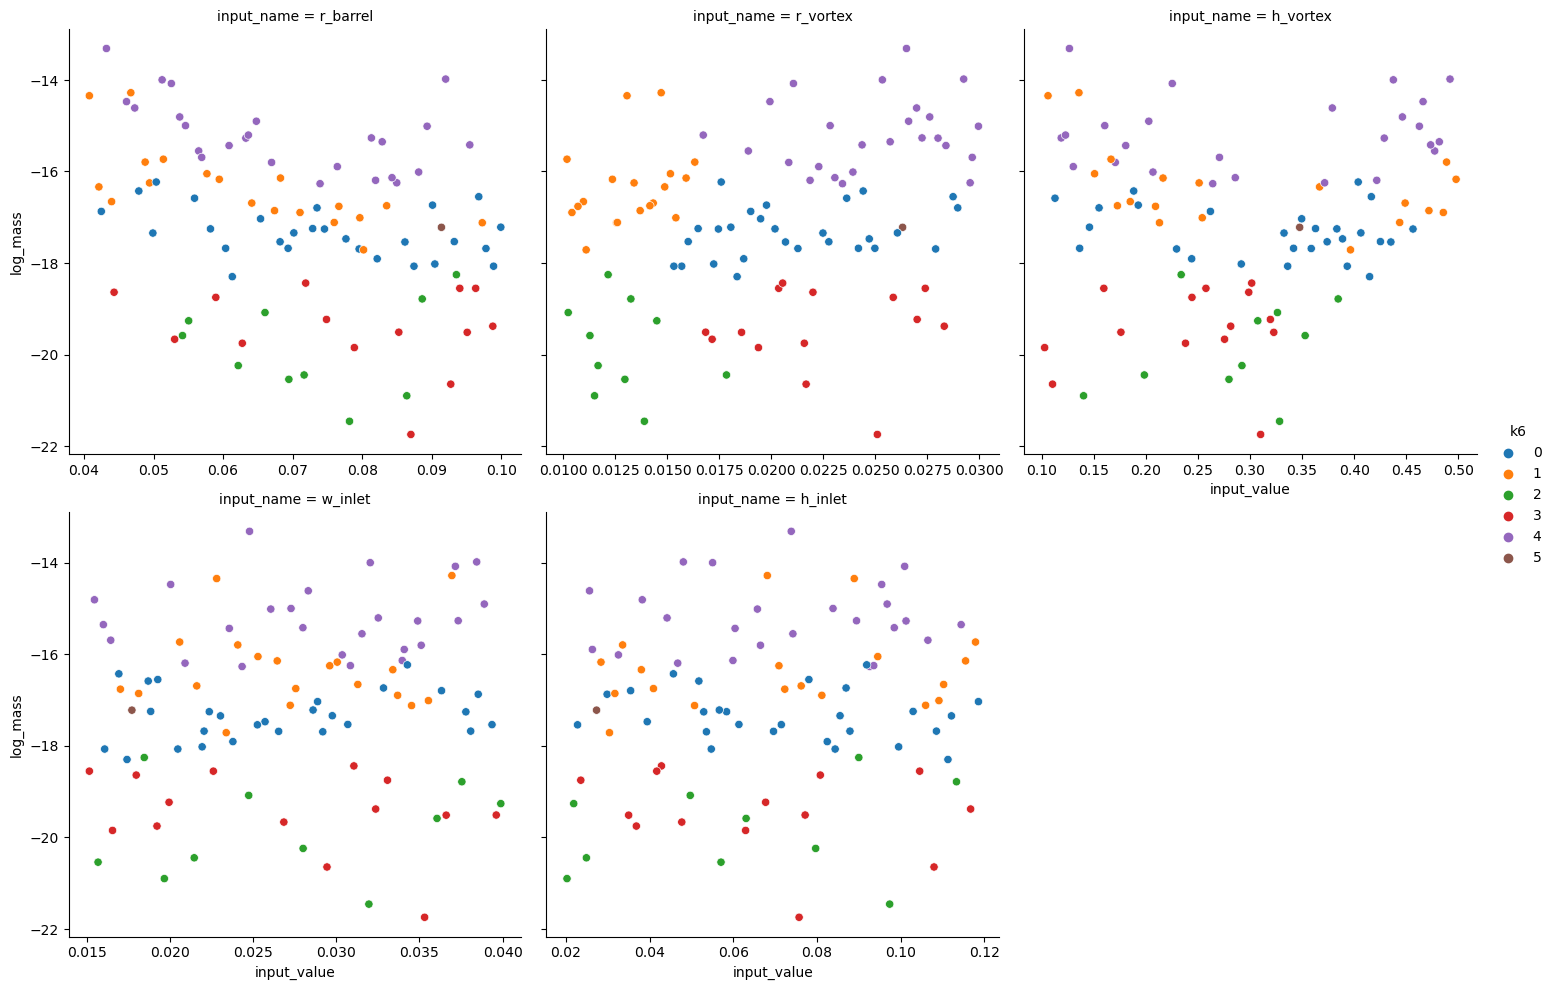

In [99]:
sns.relplot(data = lf_copy, x='input_value', y='log_mass', hue='k6', col='input_name',
            col_wrap=3, facet_kws={'sharex': False, 'sharey': True})

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


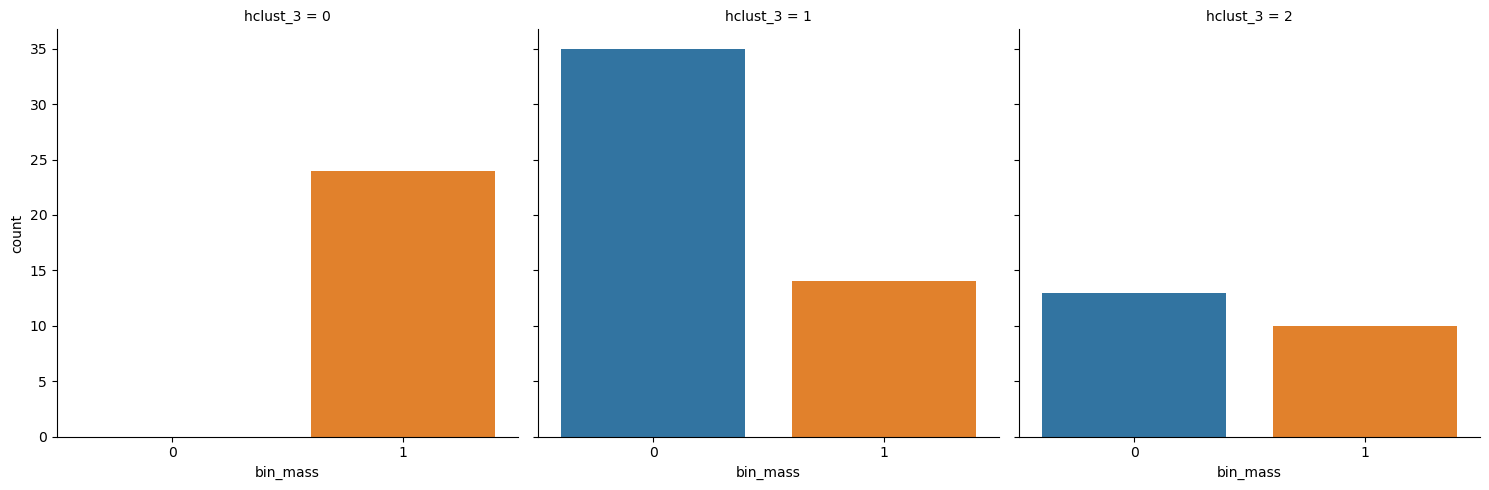

In [106]:
sns.catplot(data = df_copy, x='bin_mass', col='hclust_3',
            col_wrap=3, kind='count')

plt.show()

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


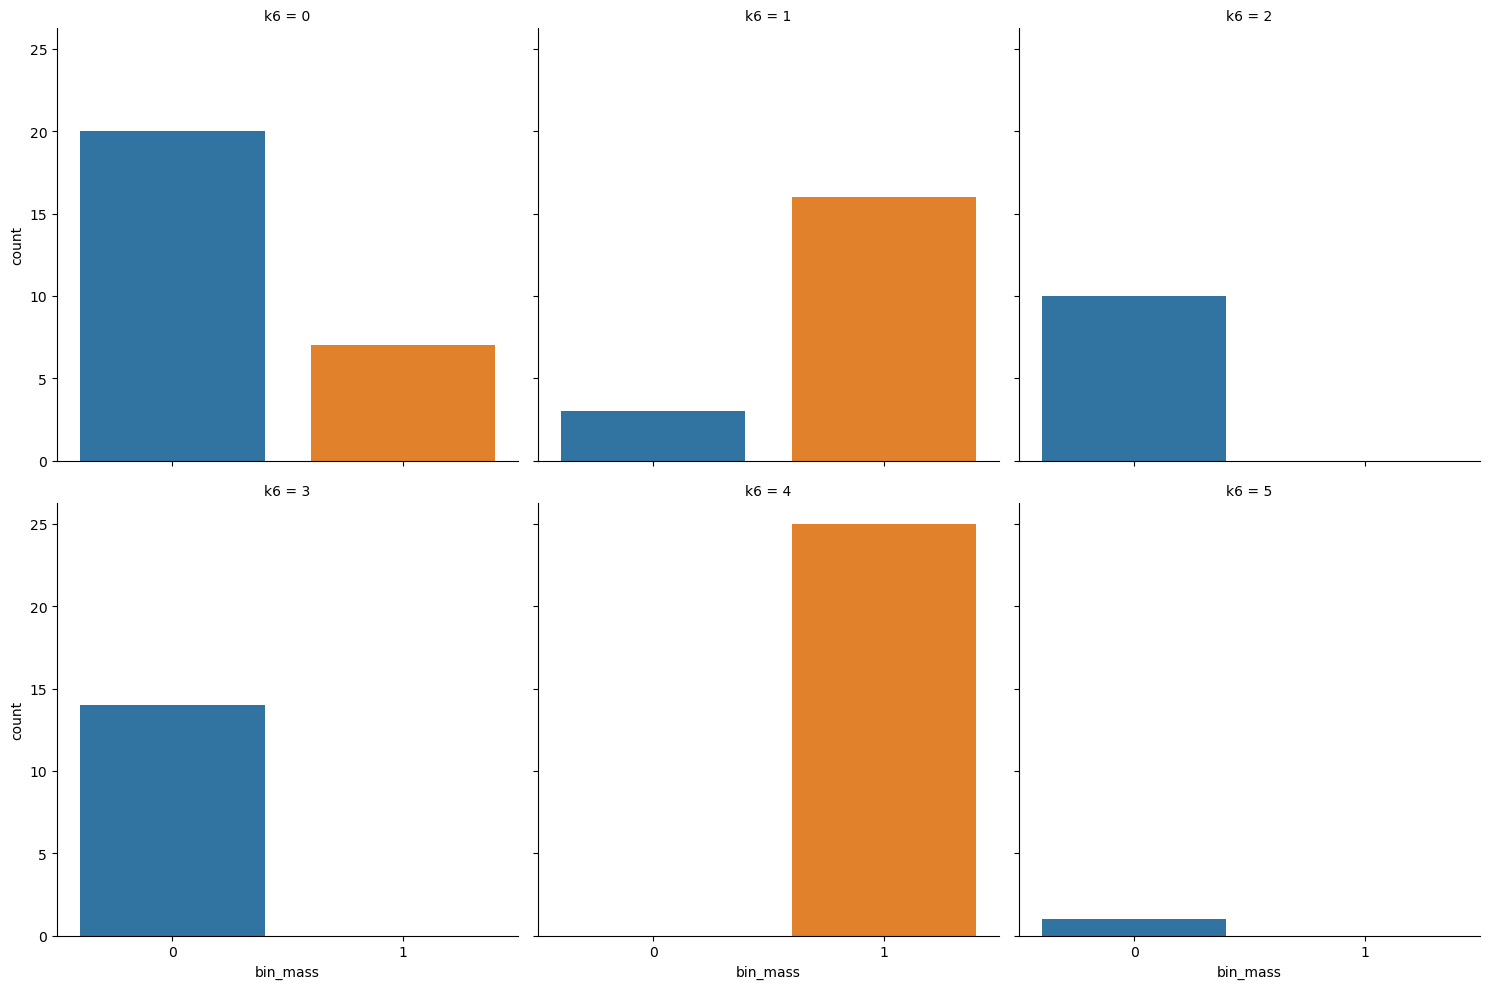

In [107]:
sns.catplot(data = df_cluster_copy, x='bin_mass', col='k6',
            col_wrap=3, kind='count')

plt.show()